# Drug plates

In [1]:
library(ggplot2)
library(extrafont)
library(stringr)
library(heatmaply)
library(ggrepel)
library(reticulate)
library(gridExtra)
library(robustbase)
library(randomForest)

Registering fonts with R
Loading required package: plotly

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: viridis
Loading required package: viridisLite

Welcome to heatmaply version 0.15.2

Type citation('heatmaply') for how to cite the package.
Type ?heatmaply for the main documentation.

The github page is: https://github.com/talgalili/heatmaply/
Please submit your suggestions and bug-reports at: https://github.com/talgalili/heatmaply/issues
Or contact: <tal.galili@gmail.com>

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [2]:
# Load external Python functions
source_python("reticulate_functions.py")
# Load extra fonts
loadfonts()
# Set this to true for faster compilation or false for more precise results and all outputs
TEST_MODE = T

Sys TT already registered with pdfFonts().
Lato Black already registered with pdfFonts().
Lato already registered with pdfFonts().
Lato Hairline already registered with pdfFonts().
Lato Light already registered with pdfFonts().
.Keyboard already registered with pdfFonts().
More than one version of regular/bold/italic found for System Font. Skipping setup for this font.
Andale Mono already registered with pdfFonts().
More than one version of regular/bold/italic found for Apple Braille. Skipping setup for this font.
AppleMyungjo already registered with pdfFonts().
Arial Black already registered with pdfFonts().
Arial already registered with pdfFonts().
Arial Narrow already registered with pdfFonts().
Arial Rounded MT Bold already registered with pdfFonts().
Arial Unicode MS already registered with pdfFonts().
Bodoni Ornaments already registered with pdfFonts().
Bodoni 72 Smallcaps already registered with pdfFonts().
No regular (non-bold, non-italic) version of . Skipping setup for this f

In [3]:
# Number of permutations used for empirical p-value computations
PERM_NB_ITER = ifelse(TEST_MODE, 20, 2000)
# Number of genes selected for hierarchical heatmap
CLUST_NB_GENES = ifelse(TEST_MODE, 30, 300)
# Number of trees used in random forest classifier
RF_NB_TREES = ifelse(TEST_MODE, 50, 1000)

In [4]:
# Customize ggplot appearance

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
cust_pal = colorRampPalette(c("#008CAD", "#40B9D4", "#D4ECF2", "#F8B100", "#C00000", "#2D0000"))
yolla_pal = colorRampPalette(c('#FD0F91', '#C00000', '#2D0000'))
scale_fill_discrete <- function (..., type = "Cust", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else if (type == "Yolla"){
        discrete_scale(aesthetics, "Yolla", yolla_pal, na.value = na.value, ...)
    } else if (type == "Cust"){
        discrete_scale(aesthetics, "Cust", cust_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "Cust", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else if (type == "Cust"){
        discrete_scale(aesthetics, "Cust", cust_pal, na.value = na.value, ...)
    } else if (type == "Yolla"){
        discrete_scale(aesthetics, "Yolla", yolla_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)

## NK92

In [5]:
# Fix t-SNE layout and random number generation
set.seed(38)

In [6]:
NK = read.csv("./allImages_NK_Drugs.csv", header=T)

In [7]:
Layout = read.csv("./DrugPlateLayout.csv", header=T)
Layout$Well <- paste0(Layout$Row, str_pad(Layout$Column, 2, pad = "0"))

In [8]:
NK$Drug = sapply(NK$Metadata_Well, function(x) Layout$Drug[x == Layout$Well])
levels(NK$Drug)[levels(NK$Drug)=="Y27"] <- "Y-27632"
NK$Concentration = sapply(NK$Metadata_Well, function(x) Layout$Concentration[x == Layout$Well])

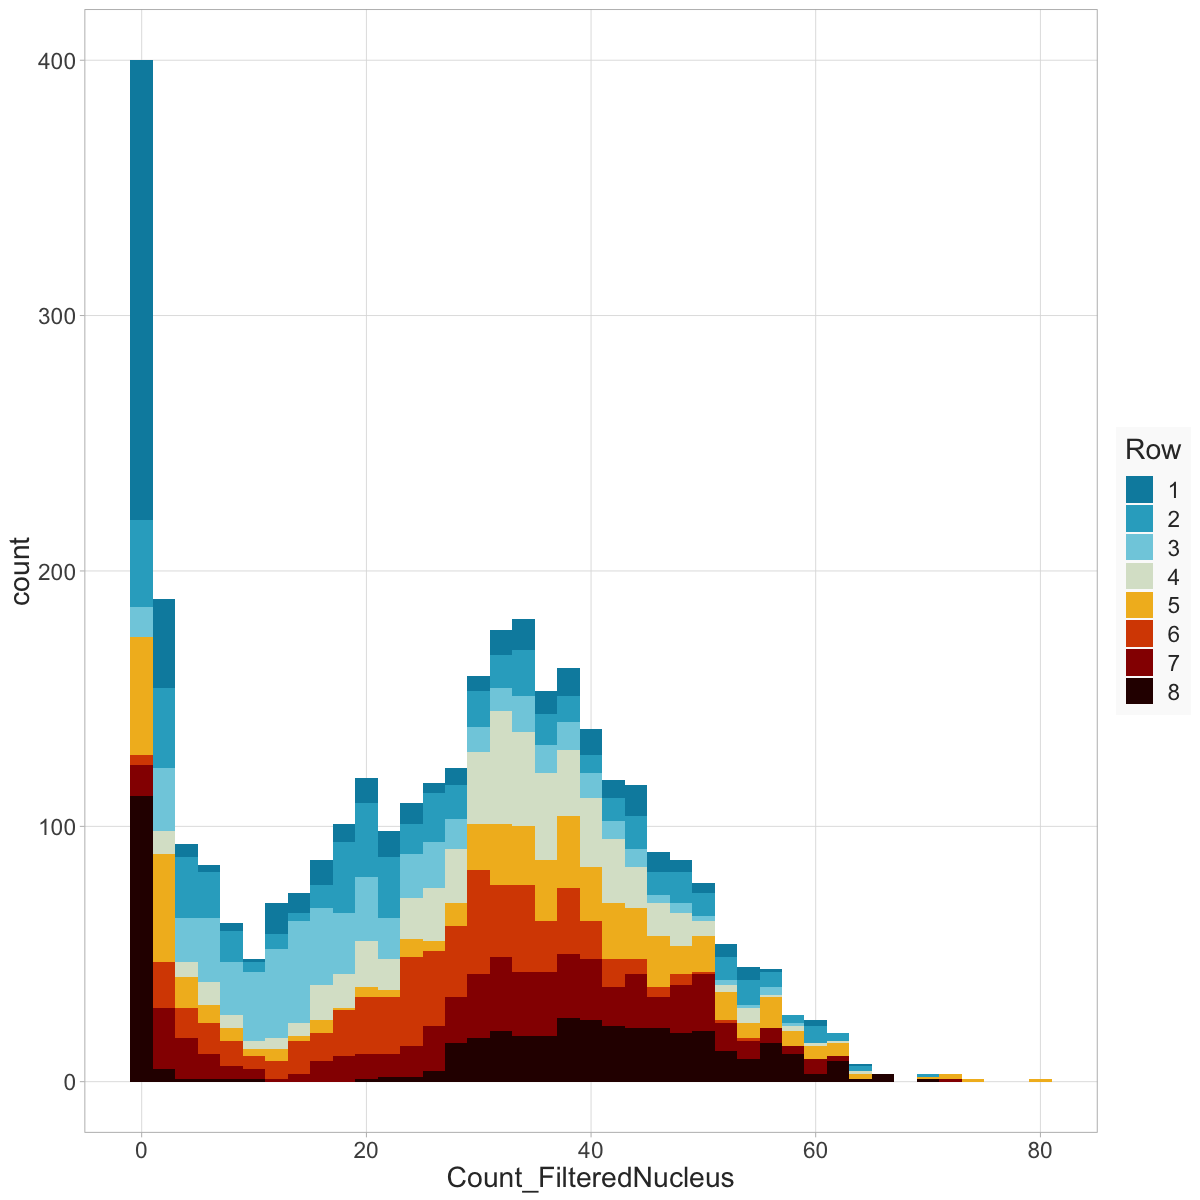

In [9]:
gpNK = ggplot(NK[!is.na(NK$Count_FilteredNucleus),]) + geom_histogram(aes(Count_FilteredNucleus, fill = as.factor(Metadata_Row)), binwidth=2) +
       scale_fill_discrete(name="Row")
gpNK

if(!TEST_MODE){
    ggsave(filename = "Fig/NK_count.pdf", plot = gpNK)
}

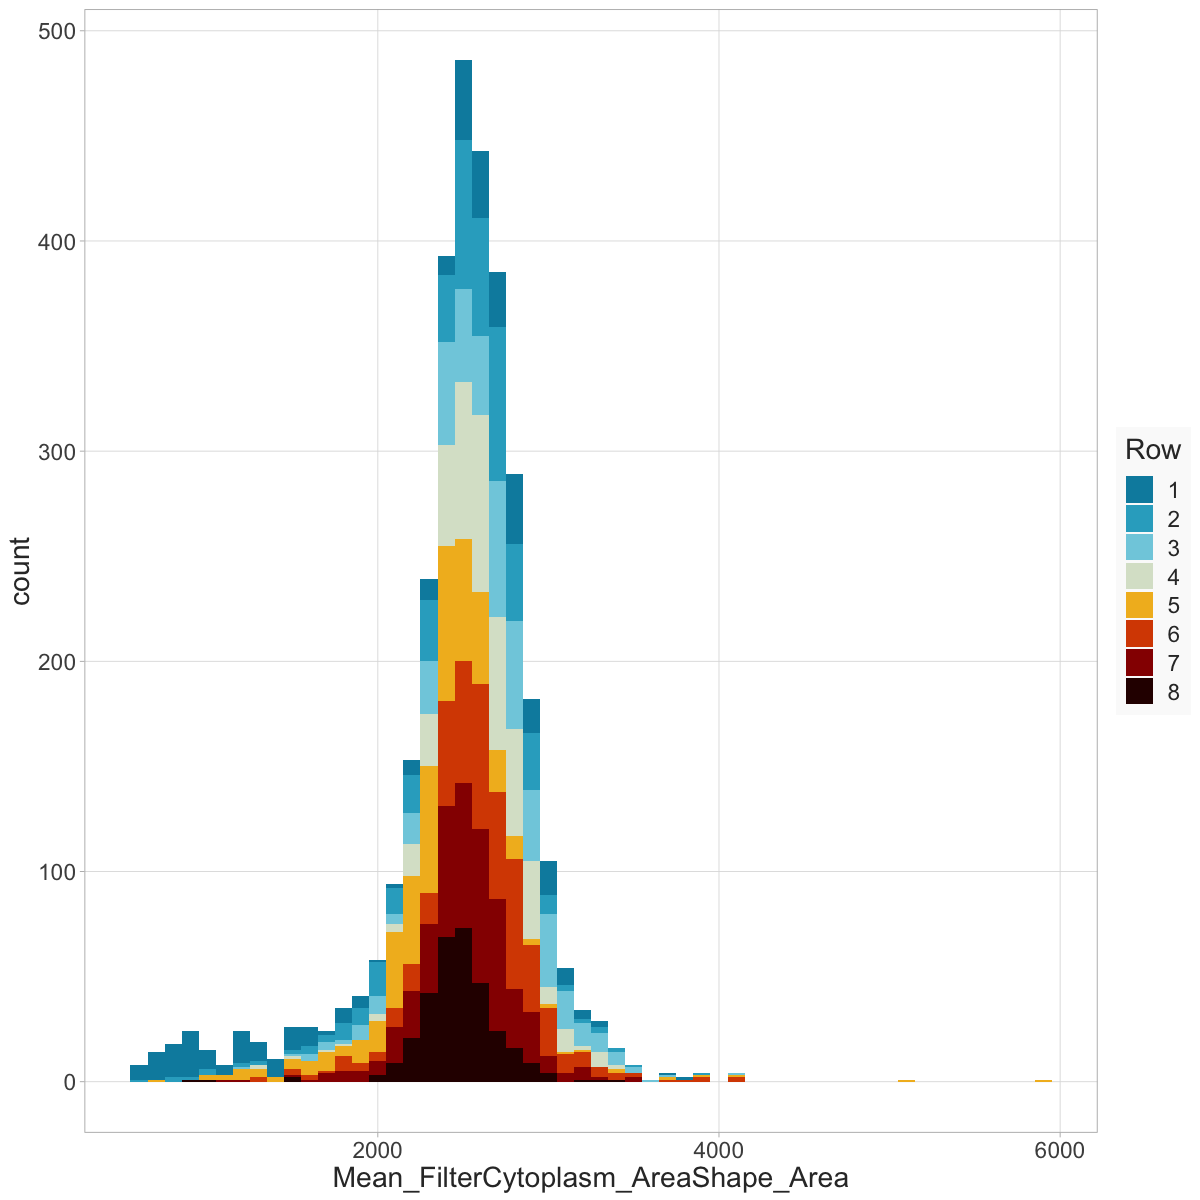

In [10]:
gpNK = ggplot(NK[!is.na(NK$Mean_FilterCytoplasm_AreaShape_Area),]) + geom_histogram(aes(Mean_FilterCytoplasm_AreaShape_Area, 
                                                                                    fill = as.factor(Metadata_Row)), binwidth=100) +
       scale_fill_discrete(name="Row")
gpNK
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_area.pdf", plot = gpNK)
}

### Filtering

In [11]:
FILT_MAX_INT_DNA = 0.05 # Remove empty images and small DNA precipitations
FILT_MIN_CELLS = 4 # 8 seems safe from distribution and images, 3 seems in poor shape
FILT_NB_MAX_NA_IMAGE = 10
FILT_MAX_CORR = 0.6 # Keep uncorrelated variables
dimUMAP = 3

In [12]:
ftToKeep = 1:dim(NK)[2]
# Make sure that the fields are numeric
ftToKeep <- ftToKeep[which(sapply(NK[,ftToKeep], class) == "numeric")]
# Remove execution time and count features
ftToKeep <- ftToKeep[grep("(Execution)|(Count)|(Concentration)", colnames(NK)[ftToKeep], invert = T)]

In [13]:
# Store all remaining features before filtering for downstream comparison to selected set
preFiltFt = colnames(NK)[ftToKeep]

In [14]:
# Remove wells with low max DNA intensity
fieldToKeep <- which(NK$ImageQuality_MaxIntensity_DNA >= FILT_MAX_INT_DNA)
# Remove wells with low cell count
fieldToKeep <- fieldToKeep[NK[fieldToKeep,]$Count_FilteredNucleus >= FILT_MIN_CELLS]

In [15]:
# Few bad quality pictures are generating a lot of missing values and are removed
fieldToKeep <- fieldToKeep[rowSums(is.na(NK[fieldToKeep,ftToKeep])) < FILT_NB_MAX_NA_IMAGE]
# Remove remaining features with missing values
ftToKeep <- ftToKeep[colSums(is.na(NK[fieldToKeep,ftToKeep])) == 0] 
# Remove constant columns
indWT = NK[fieldToKeep,]$Drug == "WT"
ftToKeep <- ftToKeep[sapply(NK[fieldToKeep,ftToKeep], function(x) mad(x) != 0)]
ftToKeep <- ftToKeep[sapply(NK[fieldToKeep[indWT],ftToKeep], function(x) mad(x) != 0)]

In [16]:
length(apply(NK[fieldToKeep,ftToKeep], 2, function(x) mad(x) != 0))

[1] 1857

In [17]:
length(sapply(NK[fieldToKeep,ftToKeep], function(x) mad(x) != 0))

[1] 1857

In [18]:
length(sapply(NK[fieldToKeep,ftToKeep], function(x) mad(x) != 0))
length(ftToKeep)

[1] 1857

[1] 1857

In [19]:
print(dim(NK))
print(length(ftToKeep))
print(length(fieldToKeep))

[1] 3520 1945
[1] 1857
[1] 2872


In [20]:
# Approximate normal distribution
transfLog <- function (x){
    minVal = min(x)
    return(log(x+1-minVal))
}

# Center and scale on control values
transfNorm <- function(x, y){
    return((x - median(y))/mad(y))
}

In [21]:
transformedNK = apply(NK[fieldToKeep, ftToKeep], 2, transfLog)
transformedNK = apply(transformedNK, 2, function(x) transfNorm(x, x[indWT]))

In [22]:
# Order features from biggest mad to smallest mad
# Since features have mad(WT) = 1, it means that we rank features by how more variable they are
# for drug perturbations than for WT
orderFt = rev(order(apply(transformedNK, 2, mad)))

In [23]:
uncorrFt = uncorrelate(transformedNK, orderCol = orderFt-1, threshold = FILT_MAX_CORR)
uncorrFt = unlist(uncorrFt) + 1

In [24]:
transformedNK = transformedNK[,uncorrFt]

### Export subset of features

For NK cells, the following features are selected and explored separately for their biological interpretability:
```
* Actin intensity/cell (mean/well): NK$Intensity_MeanIntensity_CorrActin_FilterCytoplasm
* Cell area: NK$Mean_FilterCytoplasm_AreaShape_Area
* Cell roundness: NK$Mean_FilterCytoplasm_AreaShape_FormFactor
* Cell width: NK$Mean_FilterCytoplasm_AreaShape_MajorAxisLength 
* Cell length: NK$Mean_FilterCytoplasm_AreaShape_MinorAxisLength
* Cell length to width ratio: NK$Mean_FilterCytoplasm_AreaShape_MinorAxisLength / NK$Mean_FilterCytoplasm_AreaShape_MajorAxisLength
* Average number of perforin granules / cell: NK$Count_PerfGranules  / NK$Count_FilterCytoplasm
* Perforin area / cell area: (NK$Count_PerfGranules * NK$Mean_PerfGranules_AreaShape_Area)  / (NK$Count_FilterCytoplasm * NK$Mean_FilterCytoplasm_AreaShape_Area)
* Perforin intensity: NK$Intensity_MeanIntensity_CorrPerf_FilterCytoplasm
* Perforin area: NK$Mean_PerfGranules_AreaShape_Area
* Nucleus intensity: NK$Intensity_MeanIntensity_CorrDNA_FilteredNucleus
* Nucleus area: NK$Mean_FilteredNucleus_AreaShape_Area
* Nucleus roundness: NK$Mean_FilteredNucleus_AreaShape_FormFactor
* Nucleus width: NK$Mean_FilteredNucleus_AreaShape_MajorAxisLength 
* Nucleus length: NK$Mean_FilteredNucleus_AreaShape_MinorAxisLength
* Nucleus ratio: NK$Mean_FilteredNucleus_AreaShape_MinorAxisLength / NK$Mean_FilteredNucleus_AreaShape_MajorAxisLength
* Nucleus area / cell area: (NK$Count_FilteredNucleus * NK$Mean_FilteredNucleus_AreaShape_Area)  / (NK$Count_FilterCytoplasm * NK$Mean_FilterCytoplasm_AreaShape_Area)```

NB (from CellProfiler docs): FormFactor = $4 \times π \times Area / Perimeter^2$. Equals 1 for a perfectly circular object.

In [25]:
subsetNK = cbind(Field = str_extract(as.character(NK[fieldToKeep,]$URL_Actin), "r..c..f.."),
                 Drug = as.character(NK[fieldToKeep,]$Drug),
                 Concentration = NK[fieldToKeep,]$Concentration,
                 ActinIntensity = NK[fieldToKeep,]$Intensity_MeanIntensity_CorrActin_FilterCytoplasm,
                 CellArea = NK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_Area,
                 CellRoundness = NK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_FormFactor,
                 CellWidth = NK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_MajorAxisLength,
                 CellLength = NK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_MinorAxisLength,
                 CellLengthOverWidth = NK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_MinorAxisLength / 
                     NK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_MajorAxisLength,
                 PerforinGranulesPerCell = NK[fieldToKeep,]$Count_PerfGranules  / NK[fieldToKeep,]$Count_FilterCytoplasm,
                 PerforinAreaOverCellArea = (NK[fieldToKeep,]$Count_PerfGranules * NK[fieldToKeep,]$Mean_PerfGranules_AreaShape_Area) / 
                     (NK[fieldToKeep,]$Count_FilterCytoplasm * NK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_Area),
                 PerforinIntensity = NK[fieldToKeep,]$Intensity_MeanIntensity_CorrPerf_FilterCytoplasm,
                 PerforinArea = NK[fieldToKeep,]$Mean_PerfGranules_AreaShape_Area,
                 NucleusIntensity = NK[fieldToKeep,]$Intensity_MeanIntensity_CorrDNA_FilteredNucleus,
                 NucleusArea = NK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_Area,
                 NucleusRoundness = NK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_FormFactor,
                 NucleusWidth = NK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_MajorAxisLength,
                 NucleusLength = NK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_MinorAxisLength,
                 NucleusLengthOverWidth = NK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_MinorAxisLength / 
                     NK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_MajorAxisLength,
                 NucleusAreaOverCellArea = (NK[fieldToKeep,]$Count_FilteredNucleus * NK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_Area) / 
                 (NK[fieldToKeep,]$Count_FilterCytoplasm * NK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_Area)
                )

In [26]:
# Export list of "interpretable" features
if(!TEST_MODE){
    write.csv(subsetNK, "Tab/NK_Drug_features.csv", row.names = F)
}

### Look at which types of features are kept


  0   1 
196 186 

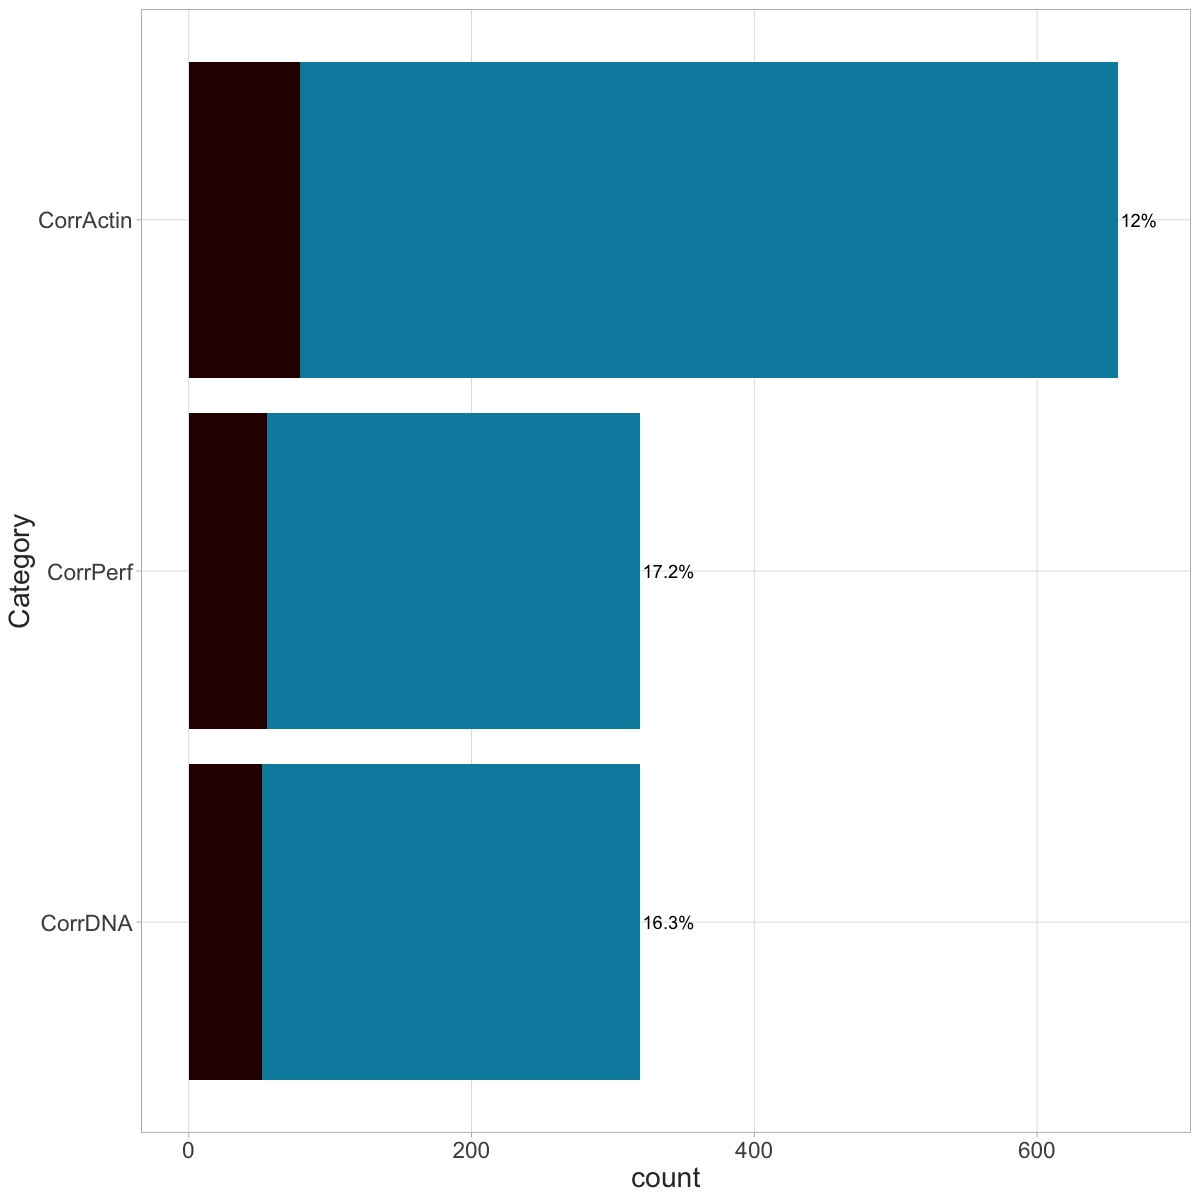

In [27]:
catChannel = c("CorrDNA", "CorrActin", "CorrPerf")
table(rowSums(sapply(catChannel, function(x) grepl(x, colnames(transformedNK)))))
dtCat = data.frame(CountIni = sort(colSums(sapply(catChannel, function(x) grepl(x, preFiltFt)))), 
                   Count = sort(colSums(sapply(catChannel, function(x) grepl(x, colnames(transformedNK))))))

dtCat$Order <- rank(dtCat$CountIni, ties.method = c("first"))
dtCat$Category <- factor(rownames(dtCat), levels=rownames(dtCat)[order(dtCat$CountIni)])
dtCat$Ratio <- dtCat$Count / dtCat$CountIni
dtCat$Ratio <- paste0(round(100*dtCat$Ratio, 1), "%")
gp <- ggplot(dtCat) + geom_bar(aes(Category, weight = CountIni), fill = cust_pal(2)[1]) + ylim(c(0,675)) +
              geom_bar(aes(Category, weight = Count), fill = cust_pal(2)[2]) + 
              geom_text(aes(x = Order, y = CountIni + 2, label = Ratio), hjust = 0) + coord_flip()
gp

In [28]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_SelecFt_Channel.pdf", plot = gp, width = 10)
}


  0   1   2 
 55 319   8 

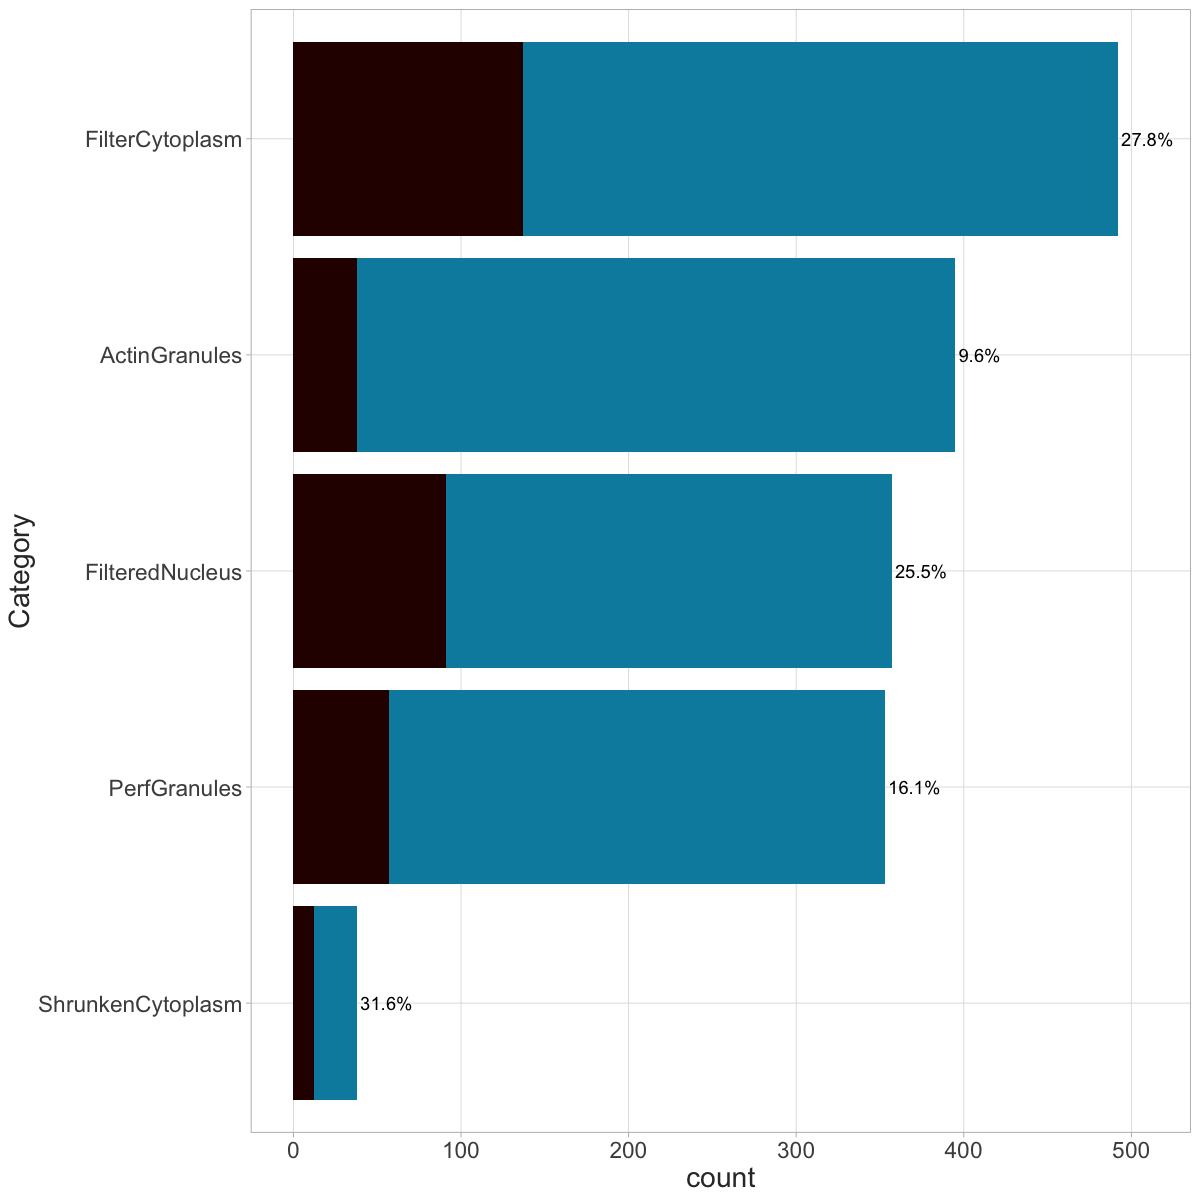

In [29]:
catObjects = c("ActinGranules", "FilterCytoplasm", "ShrunkenCytoplasm", "FilteredNucleus", "PerfGranules")
table(rowSums(sapply(catObjects, function(x) grepl(x, colnames(transformedNK)))))
dtCat = data.frame(CountIni = colSums(sapply(catObjects, function(x) grepl(x, preFiltFt))), 
                   Count = colSums(sapply(catObjects, function(x) grepl(x, colnames(transformedNK)))))

dtCat$Order <- rank(dtCat$CountIni, ties.method = c("first"))
dtCat$Category <- factor(rownames(dtCat), levels=rownames(dtCat)[order(dtCat$CountIni)])
dtCat$Ratio <- dtCat$Count / dtCat$CountIni
dtCat$Ratio <- paste0(round(100*dtCat$Ratio, 1), "%")
gp <- ggplot(dtCat) + geom_bar(aes(Category, weight = CountIni), fill = cust_pal(2)[1]) + ylim(c(0,510)) +
              geom_bar(aes(Category, weight = Count), fill = cust_pal(2)[2]) + 
              geom_text(aes(x = Order, y = CountIni + 2, label = Ratio), hjust = 0) + coord_flip()
gp

In [30]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_SelecFt_Object.pdf", plot = gp, width = 10)
}

integer(0)

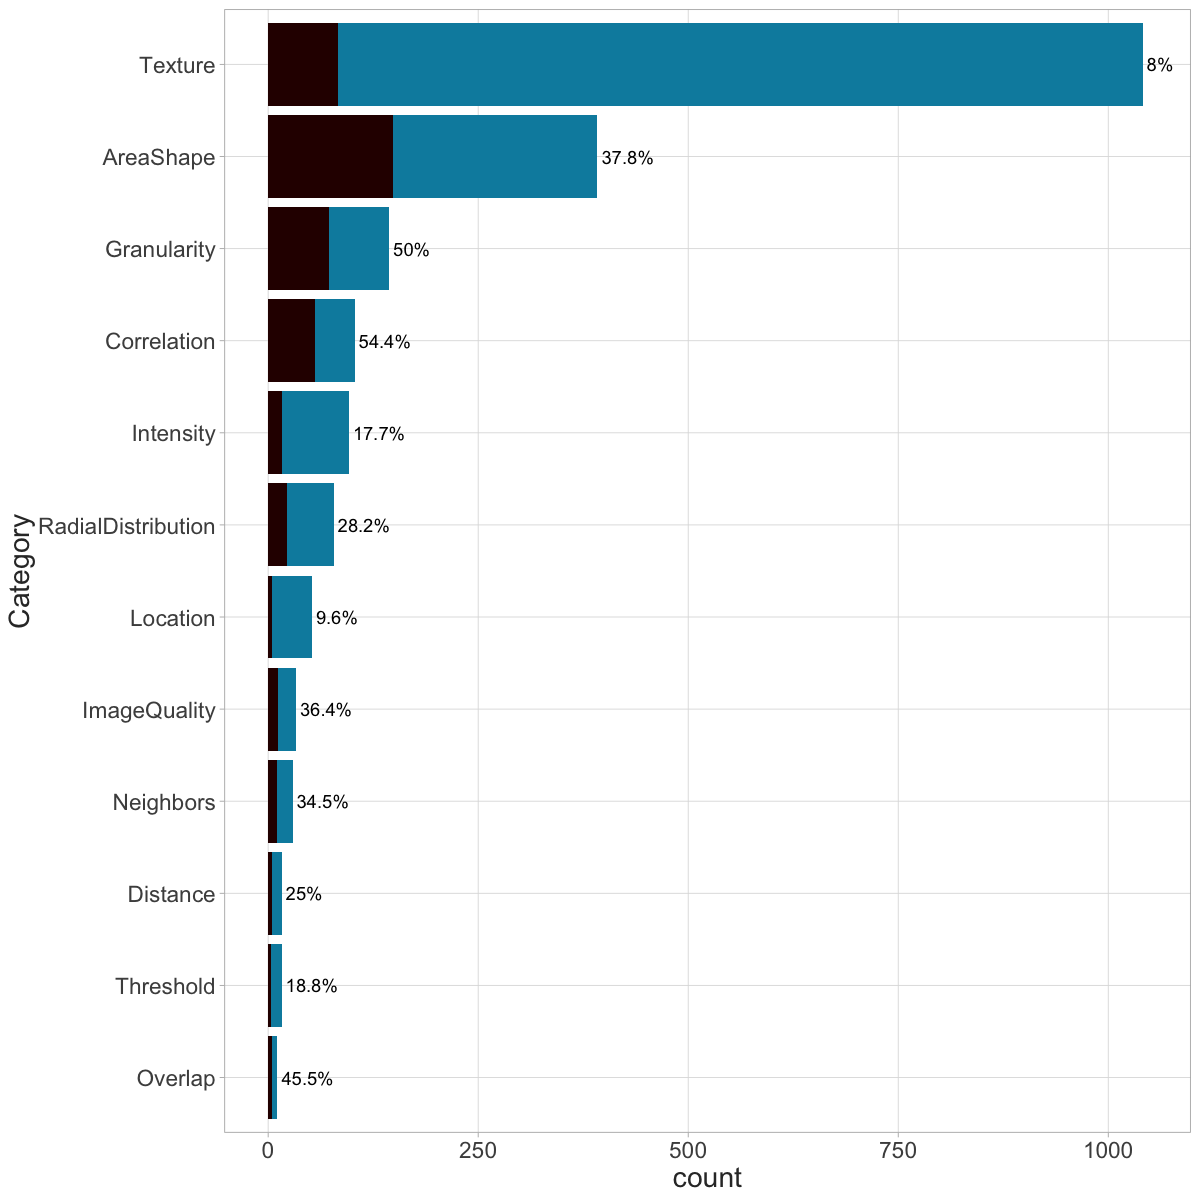

In [31]:
catType = c("Threshold", "Granularity", "ImageQuality", "Texture", "Distance", "AreaShape", "RadialDistribution", "Neighbors", 
            "Correlation", "Intensity", "Overlap", "Location")
which(rowSums(sapply(catType, function(x) grepl(x, colnames(transformedNK)))) == 0) # All features are covered

dtCat = data.frame(CountIni = colSums(sapply(catType, function(x) grepl(x, preFiltFt))), 
                   Count = colSums(sapply(catType, function(x) grepl(x, colnames(transformedNK)))))
dtCat$Order <- rank(dtCat$CountIni, ties.method = c("first"))
dtCat$Category <- factor(rownames(dtCat), levels=rownames(dtCat)[order(dtCat$CountIni)])
dtCat$Ratio <- dtCat$Count / dtCat$CountIni
dtCat$Ratio <- paste0(round(100*dtCat$Ratio, 1), "%")
gp <- ggplot(dtCat) + geom_bar(aes(Category, weight = CountIni), fill = cust_pal(2)[1]) +
              geom_bar(aes(Category, weight = Count), fill = cust_pal(2)[2]) + 
              geom_text(aes(x = Order, y = CountIni + 5, label = Ratio), hjust = 0) + coord_flip()
gp

In [32]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_SelecFt_Type_All.pdf", plot = gp, width = 10)
}


  0   1   2 
 28 310  44 

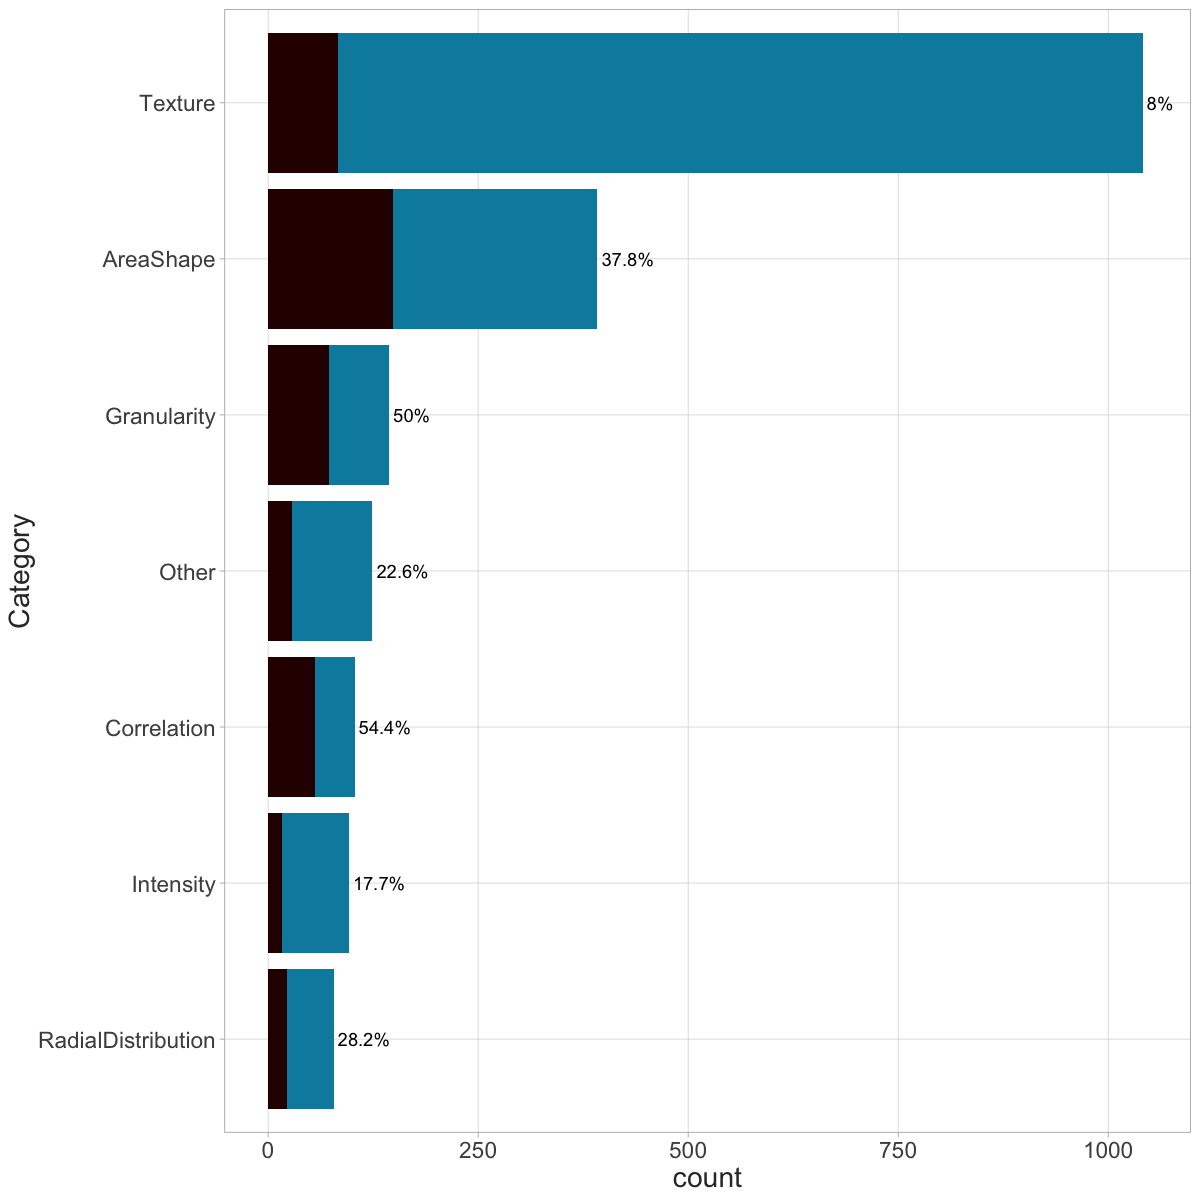

In [33]:
catType = c("Granularity", "Texture", "AreaShape", "RadialDistribution",
            "Correlation", "Intensity")
table(rowSums(sapply(catType, function(x) grepl(x, colnames(transformedNK)))))

dtCount = as.data.frame(sapply(catType, function(x) grepl(x, colnames(transformedNK))))
dtCount$Other = !apply(dtCount, 1, any)
dtCountIni = as.data.frame(sapply(catType, function(x) grepl(x, preFiltFt)))
dtCountIni$Other = !apply(dtCountIni, 1, any)
dtCat = data.frame(CountIni = colSums(dtCountIni), 
                   Count = colSums(dtCount))
dtCat$Order <- rank(dtCat$CountIni, ties.method = c("first"))
dtCat$Category <- factor(rownames(dtCat), levels=rownames(dtCat)[order(dtCat$CountIni)])
dtCat$Ratio <- dtCat$Count / dtCat$CountIni
dtCat$Ratio <- paste0(round(100*dtCat$Ratio, 1), "%")
gp <- ggplot(dtCat) + geom_bar(aes(Category, weight = CountIni), fill = cust_pal(2)[1]) +
              geom_bar(aes(Category, weight = Count), fill = cust_pal(2)[2]) + 
              geom_text(aes(x = Order, y = CountIni + 5, label = Ratio), hjust = 0) + coord_flip()
gp

In [34]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_SelecFt_Type_Short.pdf", plot = gp, width = 10)
}

In [35]:
# Export list of features kept
if(!TEST_MODE){
    write.table(colnames(transformedNK), file = "Tab/NK_list_features.csv", col.names = F, row.names = F)
}

### Look at the morphological distribution of the fields of view

#### UMAP visualizations

In [36]:
umTNK = umap(transformedNK, min_dist = 0.1, neighbors = 10, n = dimUMAP, metric = "euclidean")
umTNK = as.data.frame(umTNK)
names(umTNK) = c("UMAP1", "UMAP2", "UMAP3")
umTNK$Row <- as.factor(NK$Metadata_Row[fieldToKeep])
umTNK$Col <- as.factor(NK$Metadata_Column[fieldToKeep])
umTNK$Drug <- as.factor(NK$Drug[fieldToKeep])
umTNK$Conc <- as.factor(NK$Concentration[fieldToKeep])
umTNK$URL <- as.factor(NK$URL_Actin[fieldToKeep])

In [37]:
# Order levels to separate DMSO and WT from drugs
lvDMSO = which(levels(umTNK$Drug) == "DMSO")
lvWT = which(levels(umTNK$Drug) == "WT")
umTNK$Drug <- factor(umTNK$Drug, levels = c("DMSO", rev(levels(umTNK$Drug)[-c(lvDMSO, lvWT)]), "WT"))

In [38]:
umTNK$Shape = ifelse(umTNK$Drug %in% c("DMSO", "WT"), "2", "1")

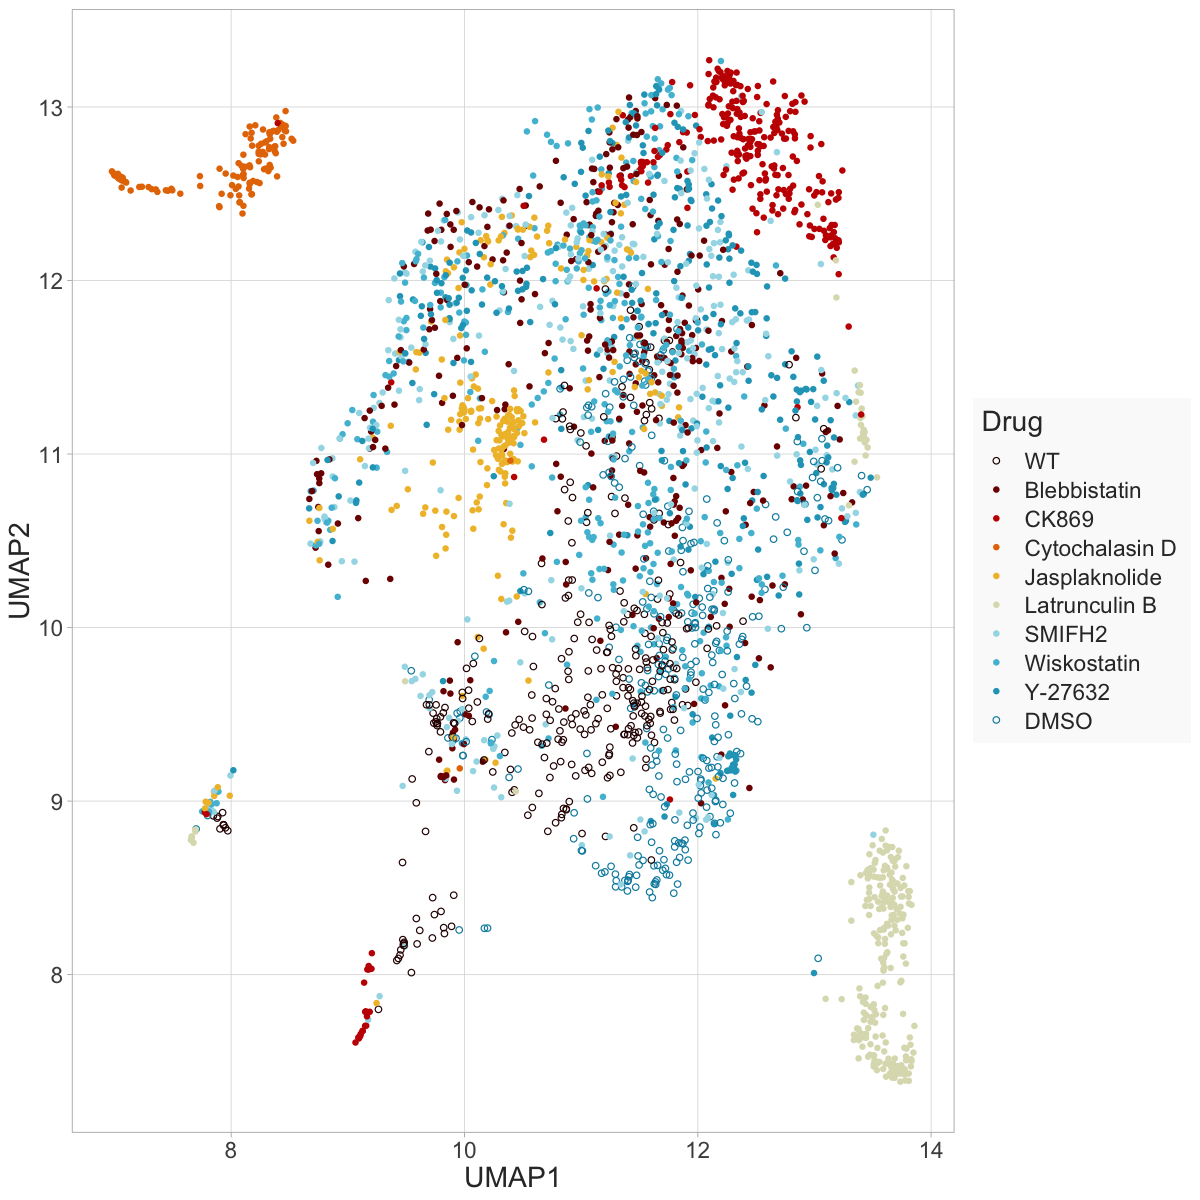

In [39]:
gp <- ggplot(umTNK) + geom_point(aes(UMAP1, UMAP2, color = Drug, shape = Shape)) + 
                      guides(color = guide_legend(reverse = TRUE, 
                               override.aes = list(shape = ifelse(levels(umTNK$Drug) %in% c("DMSO", "WT"), 1, 16))),
                             shape = F) + scale_shape_manual(values = c(16,1))
gp

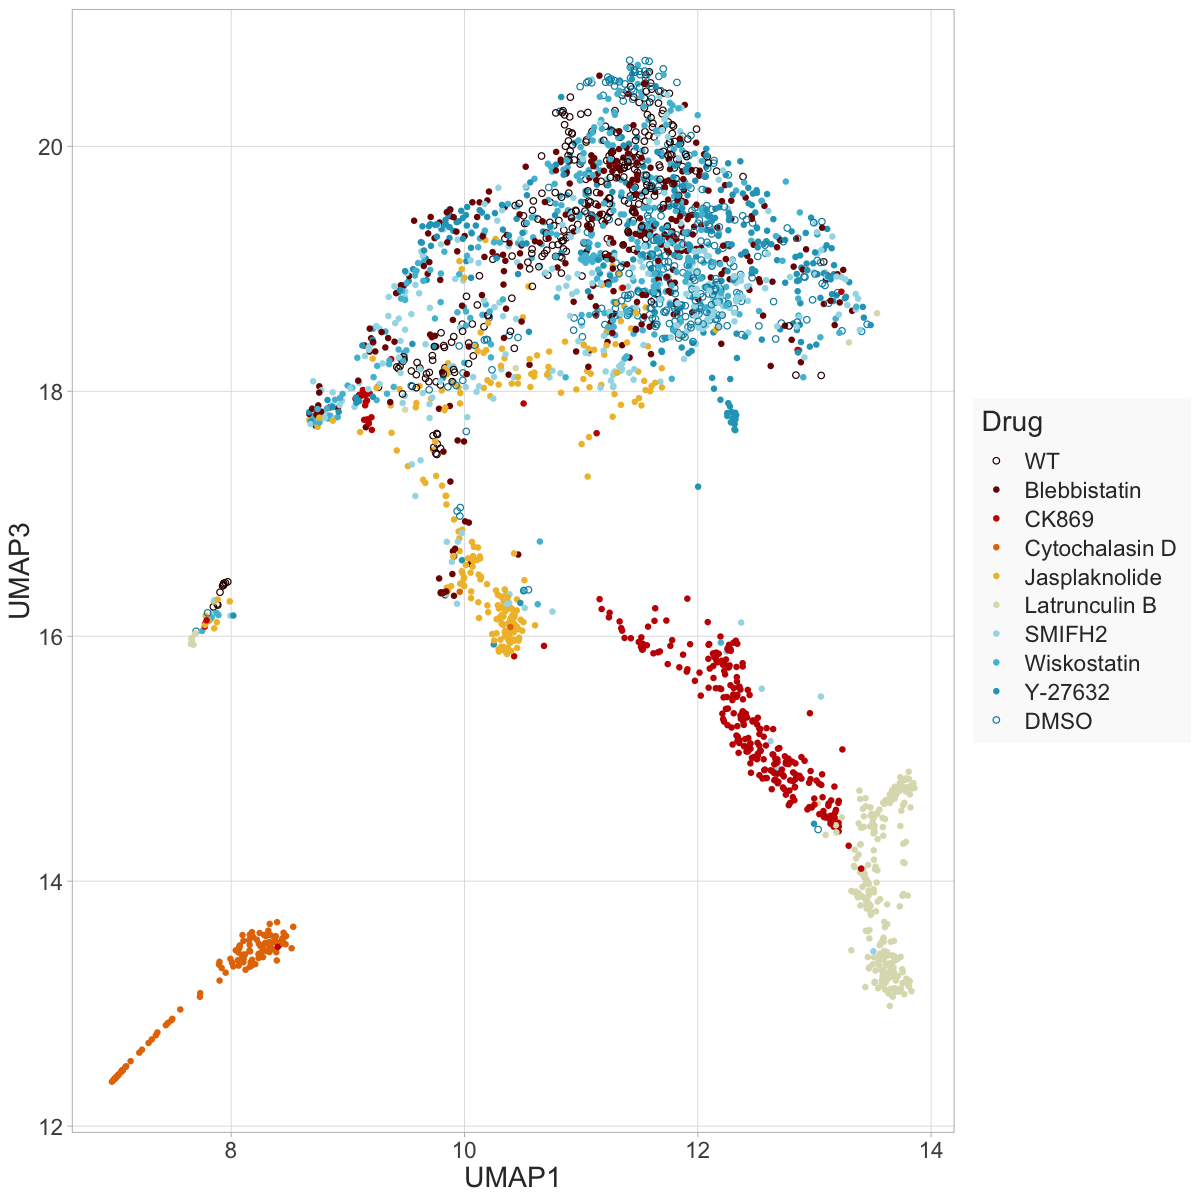

In [40]:
gp <- ggplot(umTNK) + geom_point(aes(UMAP1, UMAP3, color = Drug, shape = Shape)) + 
                      guides(color = guide_legend(reverse = TRUE, 
                               override.aes = list(shape = ifelse(levels(umTNK$Drug) %in% c("DMSO", "WT"), 1, 16))),
                             shape = F) + scale_shape_manual(values = c(16,1))
gp

#### Alternate drug colors

    umTNK$Drug = factor(umTNK$Drug, levels = c('DMSO', 'Latrunculin B', 'Cytochalasin D', 'CK869', 'Y-27632', 
                                               'Wiskostatin', 'SMIFH2', 'Jasplaknolide', 'Blebbistatin', 'WT'))
    levels(umTNK$Drug)

In [41]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_UMAP_Drugs.pdf", plot = gp, width = 10)
}

In [42]:
umXlim = ggplot_build(gp)$layout$panel_scales_x[[1]]$range$range
umYlim = ggplot_build(gp)$layout$panel_scales_y[[1]]$range$range

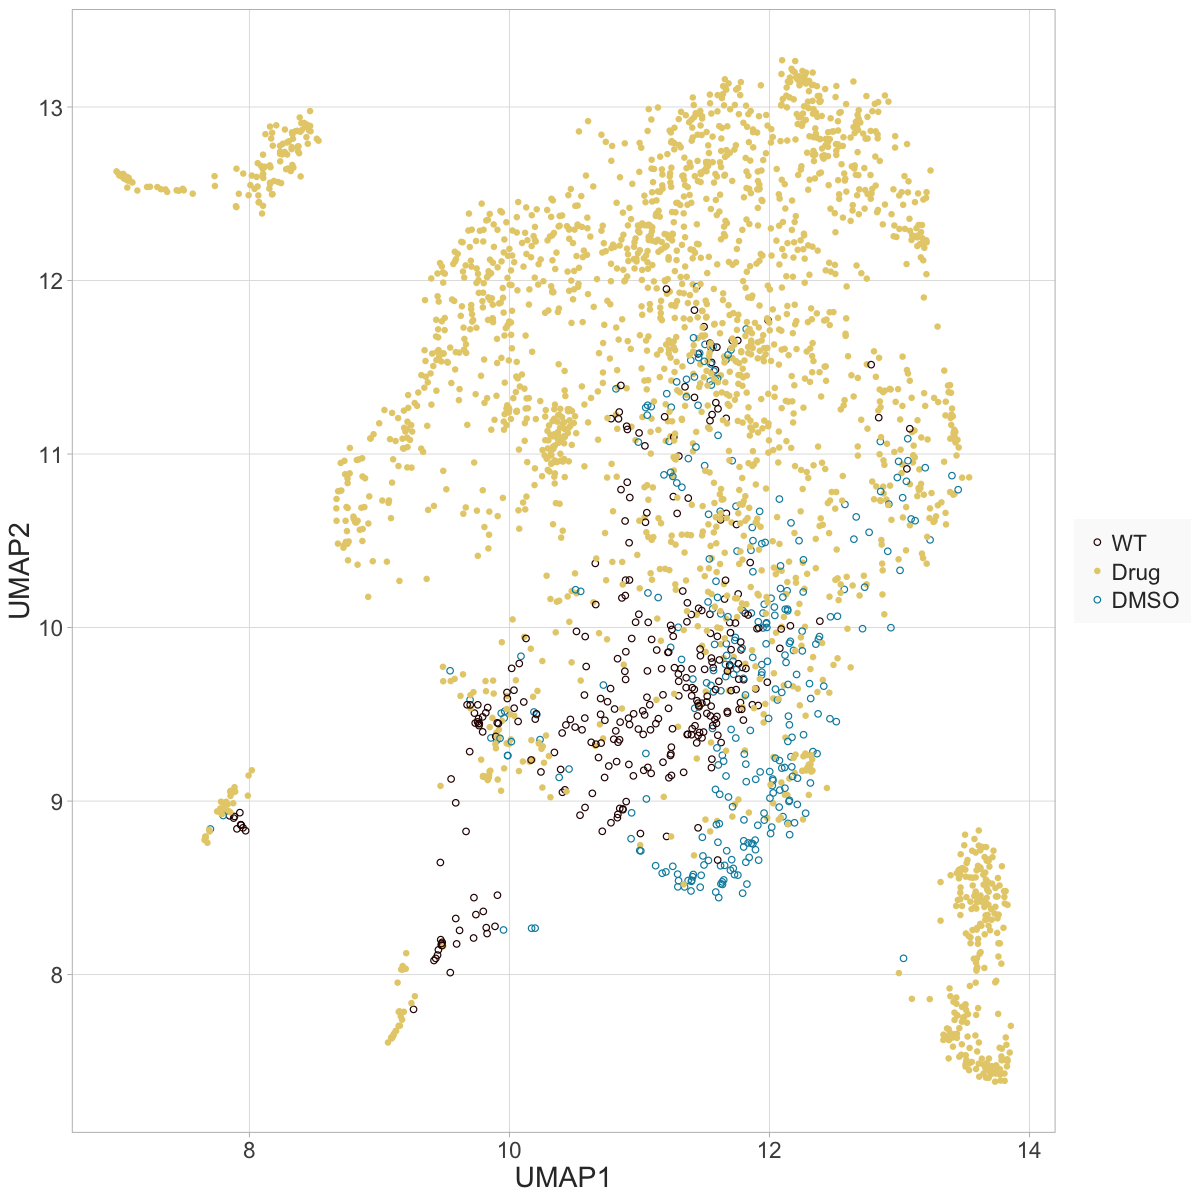

In [43]:
umTNK$DrugOrControl <- as.factor(ifelse(umTNK$Drug == "DMSO", "DMSO", ifelse(umTNK$Drug == "WT", "WT", "Drug")))

gp <- ggplot(umTNK) + geom_point(aes(UMAP1, UMAP2, color = DrugOrControl, shape = Shape)) + 
    theme(legend.title = element_blank()) + guides(color = guide_legend(reverse = TRUE, 
                               override.aes = list(shape = ifelse(levels(umTNK$DrugOrControl) %in% c("DMSO", "WT"), 1, 16))),
                             shape = F) + scale_shape_manual(values = c(16,1))
gp

In [44]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_UMAP_Control.pdf", plot = gp, width = 10)
}

In [45]:
# Visualize drug perturbations one by one
getDrugUmap <- function(drugPert){
    drug = levels(umTNK$Drug)[drugPert]
    rowPert = NK[fieldToKeep[NK[fieldToKeep,]$Drug == drug],]$Metadata_Row[1]

    umDrug = umTNK[umTNK$Row == rowPert,]
    cols = cust_pal(length(levels(umTNK$Drug)))[c(length(levels(umTNK$Drug)), drugPert, 1)]
    names(cols) = c("WT", drug, "DMSO")
    gp <- ggplot(umDrug) + geom_point(aes(UMAP1, UMAP2, color = Drug, shape = Shape)) + 
        scale_color_manual(values = cols) + ggtitle(drug) +
        theme(legend.title = element_blank(), legend.position = "bottom", legend.key.size = unit(0.08,"cm"),
              legend.text = element_text(size = 10), legend.spacing.x = unit(0.08,"cm"), text=element_text(size=12)) +
        xlim(umXlim) + ylim(umYlim) + scale_shape_manual(values = c(16,1)) +
        guides(color = guide_legend(override.aes = list(shape = c(1, 16, 1))), shape = F)
    return(gp)
}

In [46]:
if(!TEST_MODE){
    gpl = lapply(2:(length(levels(umTNK$Drug))-1), getDrugUmap)
    gp = do.call("grid.arrange", c(gpl, ncol=4))
    gp
    ggsave(filename = "Fig/NK_UMAP_by_drug.pdf", plot = gp, width = 10)
}

In [47]:
# Visualize drug perturbations one by one
getDrugConcUmap <- function(drugPert){
    drug = levels(umTNK$Drug)[drugPert]
    rowPert = NK[fieldToKeep[NK[fieldToKeep,]$Drug == drug],]$Metadata_Row[1]

    umDrug = umTNK[umTNK$Row == rowPert,]
    umDrug = umDrug[umDrug$Drug != "DMSO",]
    cols = c(yolla_pal(length(unique(umDrug[!(umDrug$Drug %in% c("WT")),]$Conc))), "#DDDDDD")
    names(cols) = c(as.character(sort(as.numeric(
                    unique(as.character(umDrug[!(umDrug$Drug %in% c("WT")),]$Conc))))), 
                                      "WT")
    
    umDrug$Conc = factor(ifelse(umDrug$Drug %in% c("WT"), "WT", as.character(umDrug$Conc)),
                         levels = names(cols))
    
    gp <- ggplot(umDrug) + geom_point(aes(UMAP1, UMAP2, color = Conc, shape = Shape)) + 
        scale_color_manual(values = cols) + ggtitle(drug) +
        theme(legend.title = element_blank(), legend.position = "bottom", legend.key.size = unit(0.08,"cm"),
              legend.text = element_text(size = 10), legend.spacing.x = unit(0.08,"cm"), text=element_text(size=12)) +
        xlim(umXlim) + ylim(umYlim) + scale_shape_manual(values = c(16,1)) +
        guides(color = guide_legend(override.aes = list(shape = c(rep(16, length(unique(umDrug$Conc))-1), 1))), shape = F)
    return(gp)
}

In [48]:
if(!TEST_MODE){
    gpl = lapply(2:(length(levels(umTNK$Drug))-1), getDrugConcUmap)
    gp = do.call("grid.arrange", c(gpl, ncol=4))
    gp
    ggsave(filename = "Fig/NK_UMAP_by_drug_concentration.pdf", plot = gp, width = 10)
}

### Prediction of drug based on morphology
Which features are useful to predict compound of origin?

Goal: 5CV + 1 fold validation

In [49]:
set.seed(38)

In [50]:
# Number of images per fold (5CV + validation set)
nbSampTestSet = round(nrow(umTNK)/6)

In [51]:
# Shuffle images
idImages = sample(length(fieldToKeep))

# Last fold will be used as validation set
validationSet = as.data.frame(transformedNK[-idImages[1:(nbSampTestSet*5)],])
validationSet$Drug = NK$Drug[fieldToKeep][-idImages[1:(nbSampTestSet*5)]]

# All drugs are present
table(validationSet$Drug)


  Blebbistatin          CK869 Cytochalasin D           DMSO  Jasplaknolide 
            63             44             24             54             33 
 Latrunculin B         SMIFH2    Wiskostatin             WT        Y-27632 
            43             50             60             49             57 

In [52]:
# F1 score for a given level
F1pred <- function(preds, obs, curLvl){
    TP = sum((preds == curLvl) & (obs == curLvl))
    FP = sum((preds == curLvl) & (obs != curLvl))
    TN = sum((preds != curLvl) & (obs != curLvl))
    FN = sum((preds != curLvl) & (obs == curLvl))
    stopifnot(length(preds) == TP+FP+TN+FN)
    stopifnot(length(obs) == TP+FP+TN+FN)
    return((2*TP)/(2*TP+FN+FP))
}

In [95]:
# Perform random forest |cross-validation on a given dataset
crossValRF <- function(dataset, folds, nbSampTestSet, idImages, mtryRange, nbTrees = RF_NB_TREES){
    # Fitness matrix (F1 score between 0 and 1, with 1 optimal)
    fitMat = matrix(ncol = folds, nrow = length(mtryRange))
    rownames(fitMat) <- as.character(mtryRange)
    for (mtryId in 1:length(mtryRange)) {
        curMtry = mtryRange[mtryId]
        print(paste("Mtry", curMtry))
        for (fold in 1:folds) {
            print(paste("Fold", fold))
            foldInd = ((fold-1)*nbSampTestSet+1):(fold*nbSampTestSet)
            testSet = dataset[foldInd,]
            trainSet = dataset[-foldInd,]

            # All classes are present in train and test sets
            stopifnot(length(table(testSet$Drug)) == 10)
            stopifnot(length(table(trainSet$Drug)) == 10)

            rf = randomForest(Drug ~ ., data = trainSet, mtry = curMtry, ntree = nbTrees)

            print(paste("Mean class error", mean(rf$confusion[,11])))
            # Prediction on test set
            preds <- predict(rf, testSet)
            # Accuracy
            print(paste("Accuracy", mean(preds == testSet$Drug)))
            # Macro F1 score
            fitMat[mtryId, fold] = mean(sapply(levels(testSet$Drug), 
                        function(x) F1pred(preds, testSet$Drug, x)))
            flush.console()
        }
    }
    return(fitMat)
}

In [54]:
datasetCV = as.data.frame(transformedNK[idImages[1:(nbSampTestSet*5)],])
datasetCV$Drug = NK$Drug[fieldToKeep][idImages[1:(nbSampTestSet*5)]]
CM = crossValRF(dataset = datasetCV, folds = 5, nbSampTestSet = nbSampTestSet, 
                idImages = idImages, mtryRange = c(20, 30, 40, 50, 60, 70, 80, 90))

[1] "Mtry 20"
[1] "Fold 1"
[1] "Mean class error 0.22165125106525"
[1] "Accuracy 0.826722338204593"
[1] "Fold 2"
[1] "Mean class error 0.230263023355452"
[1] "Accuracy 0.812108559498956"
[1] "Fold 3"
[1] "Mean class error 0.231411722580898"
[1] "Accuracy 0.801670146137787"
[1] "Fold 4"
[1] "Mean class error 0.237632529619433"
[1] "Accuracy 0.816283924843424"
[1] "Fold 5"
[1] "Mean class error 0.202609128318901"
[1] "Accuracy 0.832985386221294"
[1] "Mtry 30"
[1] "Fold 1"
[1] "Mean class error 0.20713080449105"
[1] "Accuracy 0.81419624217119"
[1] "Fold 2"
[1] "Mean class error 0.217317239504062"
[1] "Accuracy 0.824634655532359"
[1] "Fold 3"
[1] "Mean class error 0.20976106880243"
[1] "Accuracy 0.826722338204593"
[1] "Fold 4"
[1] "Mean class error 0.202547765744857"
[1] "Accuracy 0.818371607515658"
[1] "Fold 5"
[1] "Mean class error 0.196288527367429"
[1] "Accuracy 0.845511482254697"
[1] "Mtry 40"
[1] "Fold 1"
[1] "Mean class error 0.19929955968402"
[1] "Accuracy 0.807933194154488"
[1] "F

In [55]:
CM
rowMeans(CM)
optiMtry = as.numeric(rownames(CM)[rowMeans(CM) == max(rowMeans(CM))])

20,0.8413242,0.8312541,0.8152361,0.8330190,0.8430437
30,0.8337022,0.8411183,0.8390064,0.8354332,0.8592112
40,0.8236896,0.8247787,0.8633805,0.8471948,0.8303406
50,0.8445866,0.8272056,0.8651897,0.8572984,0.8412868
60,0.8419975,0.8340015,0.8381288,0.8287071,0.8311206
70,0.8582670,0.8327015,0.8509922,0.8420769,0.8448442
80,0.8479764,0.8537857,0.8628093,0.8399533,0.8367105
90,0.8638693,0.8312362,0.8324913,0.8339675,0.8288400


20        30        40        50        60        70        80        90 
0.8327754 0.8416942 0.8378768 0.8471134 0.8347911 0.8457764 0.8482471 0.8380809

In [56]:
optiMtry
fullRF = randomForest(Drug ~ ., data = datasetCV, mtry = optiMtry, ntree = RF_NB_TREES)

[1] 80

In [57]:
preds <- predict(fullRF, validationSet)
# Accuracy
print(paste("Validation accuracy", mean(preds == validationSet$Drug)))
# Macro F1-score
mean(sapply(levels(validationSet$Drug), 
            function(x) F1pred(preds, validationSet$Drug, x)))

[1] "Validation accuracy 0.840670859538784"


[1] 0.8538131

In [58]:
fullRF


Call:
 randomForest(formula = Drug ~ ., data = datasetCV, mtry = optiMtry,      ntree = RF_NB_TREES) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 80

        OOB estimate of  error rate: 20.75%
Confusion matrix:
               Blebbistatin CK869 Cytochalasin D DMSO Jasplaknolide
Blebbistatin            183     0              0   11            11
CK869                     0   235              0    0             1
Cytochalasin D            0     2             93    0             1
DMSO                      7     2              0  187             0
Jasplaknolide             2     1              1    2           196
Latrunculin B             0     0              0    5             0
SMIFH2                   17    17              1   29             5
Wiskostatin               9     1              0    6             2
WT                        2     0              0    8             1
Y-27632            

Repeat classification based on 17 hand-picked features only

In [96]:
# nbSampTestSet and idImages are kept

# Last fold will be used as validation set
validationSet = as.data.frame(subsetNK[-idImages[1:(nbSampTestSet*5)],-c(1,3)])
validationSet[,-1] = sapply(validationSet[,-1], function(x) as.numeric(as.character(x)))

# All drugs are present
table(validationSet$Drug)


  Blebbistatin          CK869 Cytochalasin D           DMSO  Jasplaknolide 
            63             44             24             54             33 
 Latrunculin B         SMIFH2    Wiskostatin             WT        Y-27632 
            43             50             60             49             57 

In [94]:
datasetCV = as.data.frame(subsetNK[idImages[1:(nbSampTestSet*5)],-c(1,3)])
datasetCV[,-1] = sapply(datasetCV[,-1], function(x) as.numeric(as.character(x)))
CM = crossValRF(dataset = datasetCV, folds = 5, nbSampTestSet = nbSampTestSet, 
                idImages = idImages, mtryRange = c(1, 5, 9, 13, 17))

[1] "Mtry 1"
[1] "Fold 1"
[1] SMIFH2        Jasplaknolide CK869         Y-27632       WT           
[6] DMSO         
10 Levels: Blebbistatin CK869 Cytochalasin D DMSO ... Y-27632
 [1] "Blebbistatin"   "CK869"          "Cytochalasin D" "DMSO"          
 [5] "Jasplaknolide"  "Latrunculin B"  "SMIFH2"         "Wiskostatin"   
 [9] "WT"             "Y-27632"       
[1] "Mean class error 0.417682184204696"
[1] "Accuracy 0.622129436325679"
[1] "Fold 2"
[1] Blebbistatin  Blebbistatin  Wiskostatin   Jasplaknolide DMSO         
[6] Wiskostatin  
10 Levels: Blebbistatin CK869 Cytochalasin D DMSO ... Y-27632
 [1] "Blebbistatin"   "CK869"          "Cytochalasin D" "DMSO"          
 [5] "Jasplaknolide"  "Latrunculin B"  "SMIFH2"         "Wiskostatin"   
 [9] "WT"             "Y-27632"       
[1] "Mean class error 0.414659551562425"
[1] "Accuracy 0.60125260960334"
[1] "Fold 3"
[1] Blebbistatin  Blebbistatin  Wiskostatin   Jasplaknolide DMSO         
[6] Wiskostatin  
10 Levels: Blebbistatin CK869 C

[1] "Mtry 17"
[1] "Fold 1"
[1] SMIFH2        Jasplaknolide CK869         Y-27632       WT           
[6] DMSO         
10 Levels: Blebbistatin CK869 Cytochalasin D DMSO ... Y-27632
 [1] "Blebbistatin"   "CK869"          "Cytochalasin D" "DMSO"          
 [5] "Jasplaknolide"  "Latrunculin B"  "SMIFH2"         "Wiskostatin"   
 [9] "WT"             "Y-27632"       
[1] "Mean class error 0.376457053210845"
[1] "Accuracy 0.624217118997912"
[1] "Fold 2"
[1] Blebbistatin  Blebbistatin  Wiskostatin   Jasplaknolide DMSO         
[6] Wiskostatin  
10 Levels: Blebbistatin CK869 Cytochalasin D DMSO ... Y-27632
 [1] "Blebbistatin"   "CK869"          "Cytochalasin D" "DMSO"          
 [5] "Jasplaknolide"  "Latrunculin B"  "SMIFH2"         "Wiskostatin"   
 [9] "WT"             "Y-27632"       
[1] "Mean class error 0.369556586430834"
[1] "Accuracy 0.62839248434238"
[1] "Fold 3"
[1] Blebbistatin  Blebbistatin  Wiskostatin   Jasplaknolide DMSO         
[6] Wiskostatin  
10 Levels: Blebbistatin CK869 

In [100]:
CM
rowMeans(CM)
optiMtry = as.numeric(rownames(CM)[rowMeans(CM) == max(rowMeans(CM))])

1,0.6363273,0.6146506,0.6278456,0.6284377,0.5938536
5,0.6492817,0.6298711,0.6486358,0.6346862,0.6350639
9,0.6449381,0.6294912,0.6410765,0.6307833,0.6358572
13,0.6564772,0.6158683,0.6304181,0.6507719,0.6636375
17,0.6343748,0.6476504,0.6341785,0.6284416,0.6283765


1         5         9        13        17 
0.6202230 0.6395077 0.6364293 0.6434346 0.6346044

In [101]:
optiMtry
fullRF = randomForest(Drug ~ ., data = datasetCV, mtry = optiMtry, ntree = RF_NB_TREES)

[1] 13

In [102]:
preds <- predict(fullRF, validationSet)
# Accuracy
print(paste("Validation accuracy", mean(preds == validationSet$Drug)))
# Macro F1-score
mean(sapply(levels(validationSet$Drug), 
            function(x) F1pred(preds, validationSet$Drug, x)))

[1] "Validation accuracy 0.677148846960168"


[1] 0.6914586

In [103]:
fullRF


Call:
 randomForest(formula = Drug ~ ., data = datasetCV, mtry = optiMtry,      ntree = RF_NB_TREES) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 13

        OOB estimate of  error rate: 39.54%
Confusion matrix:
               Blebbistatin CK869 Cytochalasin D DMSO Jasplaknolide
Blebbistatin            147     0              3    7             4
CK869                     0   219              2    7             1
Cytochalasin D            1     1             86    1             0
DMSO                      6     4              1  136            10
Jasplaknolide             7     3              4   14           127
Latrunculin B             3     4              0   12            13
SMIFH2                   32    13              8   24            30
Wiskostatin              25     7              0   27             6
WT                        8     1              1   40            12
Y-27632            

The performance is significanty reduced with the smaller set of features: 
in the additional data-driven features, there is information useful for the image classification.

#### Hierarchical clustering
##### On a subset of all images

In [ ]:
subsetID = sample(nrow(transformedNK), CLUST_NB_GENES, replace = F)

In [ ]:
start = Sys.time()
# On transformedNK
corTNK = cor(t(transformedNK[subsetID,]))
heatmaply(unname(corTNK), file = paste0("transformedNK_heatmap_", CLUST_NB_GENES, "_genes.pdf"), 
          colors = plasma, limits = c(-1,1),
          row_side_colors = NK$Drug[fieldToKeep][subsetID])
Sys.time() - start

In [ ]:
start = Sys.time()
# On umTNK
corUMap = cor(t(umTNK[subsetID,1:dimUMAP]))
heatmaply(unname(corUMap), file = paste0("transformedUMAP_heatmap_", CLUST_NB_GENES, "_genes.pdf"), 
          colors = plasma, limits = c(-1,1),
          row_side_colors = NK$Drug[fieldToKeep][subsetID])
Sys.time() - start

#### On median per well

In [ ]:
aggTNK = cbind(aggregate(transformedNK, list(str_extract(as.character(umTNK$URL), "r\\d\\dc\\d\\d")), median),
               aggregate(umTNK$Drug, list(str_extract(as.character(umTNK$URL), "r\\d\\dc\\d\\d")), dplyr::last))

In [ ]:
start = Sys.time()
# On aggregated transformedNK
corTNK = cor(t(aggTNK[,2:(1+ncol(transformedNK))]))
heatmaply(corTNK, labRow = rep(NA, ncol(corTNK)), labCol = rep(NA, ncol(corTNK)),
          file = "transformedNK_heatmap_perWell.pdf", margins = c(50,60,NA,0),
          colors = plasma, limits = c(-1,1), plot_method = "plotly",
          row_side_colors = aggTNK$x, col_side_palette = cust_pal,
          key.title = "Correlation", ylab = "Wells")
Sys.time() - start

In [ ]:
umPerWell = umap(aggTNK[,2:(1+ncol(transformedNK))], min_dist = 0.2, neighbors = 5, n = dimUMAP, metric = "euclidean")
umPerWell = as.data.frame(umPerWell)
names(umPerWell) = c("UMAP1", "UMAP2")
umPerWell$Drug <- as.factor(aggTNK$x)

In [ ]:
gp <- ggplot(umPerWell) + geom_point(aes(UMAP1, UMAP2, color = Drug)) + 
                      guides(color = guide_legend(reverse = TRUE, 
                               override.aes = list(shape = ifelse(levels(umPerWell$Drug) %in% c("DMSO", "WT"), 1, 16))))
gp

In [ ]:
start = Sys.time()
# On umap per well
corUMap = cor(t(umPerWell[,1:dimUMAP]))
heatmaply(corUMap, labRow = rep(NA, ncol(corTNK)), labCol = rep(NA, ncol(corTNK)),
          file = "transformedUMAP_heatmap_perWell.pdf", margins = c(50,60,NA,0),
          colors = plasma, limits = c(-1,1), plot_method = "plotly",
          row_side_colors = aggTNK$x, col_side_palette = cust_pal,
          key.title = "Correlation", ylab = "Wells")
Sys.time() - start

#### UMAP of morphological features

In [ ]:
umNKFTfit = umap_fit(t(transformedNK), min_dist = 0.05, neighbors = 8, n = 2, metric = "euclidean")
umNKFT = umap_transform(umNKFTfit, t(transformedNK))
umNKFT = as.data.frame(umNKFT)
names(umNKFT) = c("UMAP1", "UMAP2")

In [ ]:
catType = c("Granularity", "Texture", "AreaShape", "RadialDistribution",
            "Correlation", "Intensity")
umNKFT$type = apply(as.data.frame(sapply(catType, function(x) 
    grepl(x, colnames(transformedNK)))), 1, function(x) paste(catType[which(x)],collapse='-'))
umNKFT$type[umNKFT$type == ""] <- NA

In [ ]:
catChannel = c("CorrDNA", "CorrActin", "CorrPerf")
umNKFT$channel = apply(as.data.frame(sapply(catChannel, function(x) 
    grepl(x, colnames(transformedNK)))), 1, function(x) paste(catChannel[which(x)],collapse='-'))
umNKFT$channel[umNKFT$channel == ""] <- NA

In [ ]:
gp <- ggplot(umNKFT) + geom_point(aes(UMAP1, UMAP2, col = type, shape = channel), size = 3)
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_UMAP_Features.pdf", gp, width = 10)
}

In [ ]:
confoundingDF = rbind(Count_Filtered_Nuclei = NK$Count_FilteredNucleus, 
                      Count_All_Nuclei = NK$Count_Nucleus,
                      Row = NK$Metadata_Row,
                      Column = NK$Metadata_Column,
                      Well = NK$Metadata_Well)[,fieldToKeep]
confoundingUMAP = umap_transform(umNKFTfit, confoundingDF)
confoundingUMAP = as.data.frame(confoundingUMAP)
names(confoundingUMAP) = c("UMAP1", "UMAP2")
confoundingUMAP$type = rownames(confoundingDF)
confoundingUMAP$size = 4

In [ ]:
confoundingAndKept = rbind(confoundingUMAP, cbind(umNKFT[,1:2], type = "Kept feature", size = 2))

In [ ]:
gp <- ggplot(confoundingAndKept) + geom_point(aes(UMAP1, UMAP2, col = type, size = size)) +
      guides(size=F) + scale_size_identity()
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_UMAP_Features_Confounding.pdf", gp, width = 10)
}

#### Distances to WT cells

In [ ]:
drugPert = "Blebbistatin"

# Find row containing this drug and split wells between WT and drug
rowPert = NK[fieldToKeep[NK[fieldToKeep,]$Drug == drugPert],]$Metadata_Row[1]
setUmapDrug = umTNK[NK[fieldToKeep,]$Drug == drugPert,1:dimUMAP]
setUmapWT = umTNK[which(indWT)[NK[fieldToKeep[indWT],]$Metadata_Row == rowPert],1:dimUMAP]

# Ensure that we have enough points to compute distance
if ((dim(setUmapDrug)[1] < 2*dimUMAP)|(dim(setUmapWT)[1] < 2*dimUMAP)){
        print(drugPert)
        RMD = NA
}

# Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
mcdWT = covMcd(setUmapWT)
RMD = median(apply(setUmapDrug, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))

In [ ]:
dim(setUmapWT)

In [ ]:
# Compute the median Robust Mahalanobis Distance (RMD) between drugs
drugRMD <- function(drugPert){
    # Find row containing this drug and split wells between WT and drug
    rowPert = NK[fieldToKeep[NK[fieldToKeep,]$Drug == drugPert],]$Metadata_Row[1]
    setUmapDrug = umTNK[NK[fieldToKeep,]$Drug == drugPert,1:dimUMAP]
    setUmapWT = umTNK[which(indWT)[NK[fieldToKeep[indWT],]$Metadata_Row == rowPert],1:dimUMAP]
    
    # Ensure that we have enough points to compute distance
    if ((dim(setUmapDrug)[1] < 2*dimUMAP)|(dim(setUmapWT)[1] < 2*dimUMAP)){
            print(drugPert)
            return(NA)
    }
    
    # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
    mcdWT = covMcd(setUmapWT)
    RMD = median(apply(setUmapDrug, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
    return(RMD)
}

In [ ]:
shuffDrugRMD <- function(drugPert, nbRep = PERM_NB_ITER){
    # Find row containing this drug and shuffle wells between WT and drug
    rowPert = NK[fieldToKeep[NK[fieldToKeep,]$Drug == drugPert],]$Metadata_Row[1]
    setUmapDrug = umTNK[NK[fieldToKeep,]$Drug == drugPert,1:dimUMAP]
    setUmapWT = umTNK[which(indWT)[NK[fieldToKeep[indWT],]$Metadata_Row == rowPert],1:dimUMAP]
    setUMAP = rbind(setUmapWT,setUmapDrug)
    shuffleRMD <- function(notUsed){
        shuffSetUMAP = rbind(setUmapWT,setUmapDrug)[sample(nrow(setUMAP)),]
        # Take random subsets of corresponding sizes
        shuffSetDrug = shuffSetUMAP[1:nrow(setUmapDrug),]
        shuffSetWT = shuffSetUMAP[(nrow(setUmapDrug)+1):(nrow(setUmapDrug)+nrow(setUmapWT)),]
        
        # Ensure that we have enough points to compute distance
        if ((dim(shuffSetDrug)[1] < 2*dimUMAP)|(dim(shuffSetWT)[1] < 2*dimUMAP)){
                print(drugPert)
                return(NA)
        }
        
        # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
        mcdWT = covMcd(shuffSetWT)
        RMD = median(apply(shuffSetDrug, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
        return(RMD)
    }
    return(sapply(1:nbRep, shuffleRMD))
}

In [ ]:
# Similar procedure for DMSO against WT
dmsoRMD <- function(rowDMSO){
    setUmapDMSO = umTNK[(NK[fieldToKeep,]$Drug == "DMSO")&(NK[fieldToKeep,]$Metadata_Row == rowDMSO),1:dimUMAP]
    setUmapWT = umTNK[which(indWT)[NK[fieldToKeep[indWT],]$Metadata_Row == rowDMSO],1:dimUMAP]
   
    # Ensure that we have enough points to compute distance
    if ((dim(setUmapDMSO)[1] < 2*dimUMAP)|(dim(setUmapWT)[1] < 2*dimUMAP)){
            return(NA)
    }
    
    # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
    mcdWT = covMcd(setUmapWT)
    RMD = median(apply(setUmapDMSO, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
    return(RMD)
}
shuffDmsoRMD <- function(rowDMSO, nbRep = PERM_NB_ITER){
    # Find row containing this drug and shuffle wells between WT and drug
    setUmapDMSO = umTNK[(NK[fieldToKeep,]$Drug == "DMSO")&(NK[fieldToKeep,]$Metadata_Row == rowDMSO),1:dimUMAP]
    setUmapWT = umTNK[which(indWT)[NK[fieldToKeep[indWT],]$Metadata_Row == rowDMSO],1:dimUMAP]
    setUMAP = rbind(setUmapWT,setUmapDMSO)
    shuffleRMD <- function(notUsed){
        shuffSetUMAP = rbind(setUmapWT,setUmapDMSO)[sample(nrow(setUMAP)),]
        # Take random subsets of corresponding sizes
        shuffSetDMSO = shuffSetUMAP[1:nrow(setUmapDMSO),]
        shuffSetWT = shuffSetUMAP[(nrow(setUmapDMSO)+1):(nrow(setUmapDMSO)+nrow(setUmapWT)),]
        
        # Ensure that we have enough points to compute distance
        if ((dim(shuffSetDMSO)[1] < 2*dimUMAP)|(dim(shuffSetWT)[1] < 2*dimUMAP)){
                return(NA)
        }
        
        # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
        mcdWT = covMcd(shuffSetWT)
        RMD = median(apply(shuffSetDMSO, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
        return(RMD)
    }
    return(sapply(1:nbRep, shuffleRMD))
}

In [ ]:
drugRMD_NK = sapply(levels(NK$Drug), drugRMD)

In [ ]:
shuffDrugRMD_NK = sapply(levels(NK$Drug), shuffDrugRMD)

In [ ]:
getRMPV <- function(x){
    ecdfRMD = ecdf(x[-1])
    return(1 - ecdfRMD(x[1]))
}
dfRMPV = data.frame(RMPV = apply(rbind(drugRMD_NK, shuffDrugRMD_NK), 2, getRMPV))

In [ ]:
dfRMPV$Drug = rownames(dfRMPV)
dfRMPV$Strength = drugRMD_NK
dfRMPV = dfRMPV[!dfRMPV$Drug %in% c("DMSO", "WT"),]
dfRMPV$adjRMPV = p.adjust(dfRMPV$RMPV, method = "fdr")

In [ ]:
gp <- ggplot(dfRMPV) + geom_point(aes(adjRMPV, Strength, color = Drug)) + geom_vline(xintercept = 0.05, color="#CCCCCC", linetype="dashed")
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_RMPV_Drugs.pdf", gp, width = 10)
}

In [ ]:
dmsoRMD_NK = sapply(1:8, dmsoRMD)
shuffDmsoRMD_NK = sapply(1:8, shuffDmsoRMD)

In [ ]:
dmsoRMPV = data.frame(RMPV = apply(rbind(dmsoRMD_NK, shuffDmsoRMD_NK), 2, getRMPV))
dmsoRMPV$Row = rownames(dmsoRMPV)
dmsoRMPV$Strength = dmsoRMD_NK
dmsoRMPV$adjRMPV = p.adjust(dmsoRMPV$RMPV, method = "fdr")

In [ ]:
gp <- ggplot(dmsoRMPV) + geom_point(aes(adjRMPV, Strength, color = Row)) + geom_vline(xintercept = 0.05, color="#CCCCCC", linetype="dashed")
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_RMPV_DMSO.pdf", plot = gp, width = 10)
}

### Concentration-dependency

In [ ]:
# Compute the Robust Mahalanobis Distance (RMD) for all images of a given drug at a given concentration
drugConcRMD <- function(drugPert, concPert){
    # Find row containing this drug and split wells between WT and drug
    rowPert = NK[fieldToKeep[NK[fieldToKeep,]$Drug == drugPert],]$Metadata_Row[1]
    pertInd = (umTNK$Drug == drugPert)&(umTNK$Conc == concPert)
    setUmapDrug = umTNK[pertInd,1:dimUMAP]
    setUmapWT = umTNK[which(indWT)[NK[fieldToKeep[indWT],]$Metadata_Row == rowPert],1:dimUMAP]
    
    # Ensure that we have enough points to compute distance
    if ((dim(setUmapDrug)[1] < 2*dimUMAP)|(dim(setUmapWT)[1] < 2*dimUMAP)){
            print(c(drugPert, concPert))
            return(NA)
    }
    
    # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
    mcdWT = covMcd(setUmapWT)
    RMD = apply(setUmapDrug, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov))
    return(RMD)
}

In [ ]:
# Which drugs should be studied?
sigDrugs = rownames(dfRMPV)[dfRMPV$adjRMPV < 0.05]
# Classify concentration per drug as follows
concentrationLevels = c("Low", "Mid", "High")

getAllDrugConcRMD <- function(d, rename = T){
    dConc = levels(droplevels(umTNK[umTNK$Drug == d,]$Conc))
    dList = sapply(dConc, function(c) drugConcRMD(d,c), simplify = F)
    if (rename){
        names(dList) <- concentrationLevels[1:length(dConc)]
    }
    return(dList)
}
sigDrugConcRMD = sapply(sigDrugs, getAllDrugConcRMD, simplify = F)

In [ ]:
getSublist <- function(x, y){
    i = which(names(x) == y)
    # If y is not a sublist of x, i is the empty integer (not null, not false but with zero-length)
    if (length(i)){
        return(x[[i]])
}}

concRMPV = sapply(concentrationLevels, function(y) unlist(sapply(sigDrugConcRMD, function(x) getSublist(x, y))))
concRMPV = as.data.frame(Reduce(rbind, Map(cbind, RMPV = concRMPV, Concentration = names(concRMPV))))
concRMPV$RMPV = as.numeric(concRMPV$RMPV)
concRMPV$Concentration = factor(concRMPV$Concentration, levels = concentrationLevels)

In [ ]:
gp <- ggplot(concRMPV) + geom_violin(aes(Concentration, RMPV, fill = Concentration)) + 
                         coord_flip() + theme(legend.title = element_blank()) + guides(fill = guide_legend(reverse = TRUE)) +
                         scale_fill_discrete(type = "Yolla")
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_ConcEffect_All.pdf", plot = gp, width = 10)
}

In [ ]:
drugsConcRMPV = sapply(sigDrugs, function(x) getAllDrugConcRMD(x, rename = F), simplify = F)

for (i in 1:length(drugsConcRMPV)){
    # Retrieve drug name and RMPV values
    drugName = names(drugsConcRMPV)[i]
    drugConcRMPV = drugsConcRMPV[[i]]
    
    # Structure into wide data frame
    concRMPV = as.data.frame(Reduce(rbind, Map(cbind, RMPV = drugConcRMPV, Concentration = names(drugConcRMPV))))
    concRMPV$RMPV = as.numeric(concRMPV$RMPV)
    # Reorder concentrations in decreasing numerical order
    concRMPV$Concentration = factor(concRMPV$Concentration, 
                                levels = as.character(sort(as.numeric(levels(concRMPV$Concentration)))))

    # Represent distribution per concentration for all significantly changed drug
    gp <- ggplot(concRMPV) + geom_violin(aes(Concentration, RMPV, fill = Concentration)) + 
                             coord_flip() + theme(legend.title = element_blank()) + guides(fill = guide_legend(reverse = T)) +
                             scale_fill_discrete(type = "Yolla")
    if(!TEST_MODE){
        ggsave(filename = paste("Fig/NK", drugName, "ConcEffect.pdf", sep = "_"), plot = gp, width = 10)
    }
}

### Morphological changes upon perturbation

In [ ]:
# Associate categories and colors to features
catType = c("Granularity", "Texture", "AreaShape", "RadialDistribution",
            "Intensity")
colType = cust_pal(length(catType)+1)

dtCount = as.data.frame(sapply(catType, function(x) grepl(x, colnames(transformedNK))))
dtCount$Other = !apply(dtCount, 1, any)
 
ftCat = as.factor(apply(dtCount, 1, function(x) colnames(dtCount)[which(x)]))

# Order levels so that "Other" is last
lvOther = which(levels(ftCat) == "Other")
ftCat = factor(ftCat, levels = c(levels(ftCat)[-lvOther], "Other"))
       
# Corresponding colors
ftCol = colType[ftCat]

In [ ]:
# Plot number of images / categories (useful to get fill color legend)
gp <- ggplot(data.frame(Category = ftCat), aes(fill = Category)) + geom_bar(aes(Category))
if(!TEST_MODE){
    ggsave(filename = "Fig/NK_CatCount.pdf", plot = gp, width = 10)
}

In [ ]:
changedFtDrug <- function(drugPert){
    # Plate row on which the drug is
    rowPert = NK[fieldToKeep[NK[fieldToKeep,]$Drug == drugPert],]$Metadata_Row[1]
    
    # Morphological features for the drug and the WT control on the same row
    setDrug = transformedNK[NK[fieldToKeep,]$Drug == drugPert,]
    setWT = transformedNK[which(indWT)[NK[fieldToKeep[indWT],]$Metadata_Row == rowPert],]
    
    medianDrug = apply(setDrug, 2, median)
    medianWT = apply(setWT, 2, median)
    medianChange = medianDrug - medianWT
    
    # Compute difference to WT
    ftToDisplay = order(abs(medianChange), decreasing = T)[1:12]
    dtChange = data.frame(Difference = medianChange[ftToDisplay])
    dtChange$Feature = rownames(dtChange)
    dtChange$Feature = factor(dtChange$Feature, levels = dtChange$Feature[order(dtChange$Difference)]) 
    dtChange$Category = ftCol[ftToDisplay]

    gp <- ggplot(dtChange) + geom_bar(aes(Feature, weight = Difference, fill = Category), color = "#CCCCCC") + 
                   coord_flip() + ylab("Difference to WT") + scale_fill_identity() +
                   theme(legend.position="none", plot.margin=unit(c(0,5,0,0), "mm"))
    
    if(!TEST_MODE){
        ggsave(filename = paste("Fig/NK", drugPert, "ChangeFt.pdf", sep = "_"), plot = gp, width = 10)
    }
}

In [ ]:
sapply(sigDrugs, changedFtDrug)

## Is concentration-dependent effect acting on similar or distinct features?
Example of Y27

In [ ]:
changedFtY27 <- function(concPert){  
    drugPert = "Y27"
    
    # Plate row on which the drug is
    rowPert = NK[fieldToKeep[NK[fieldToKeep,]$Drug == drugPert],]$Metadata_Row[1]
    
    # Morphological features for the drug and the WT control on the same row
    setDrug = transformedNK[(NK[fieldToKeep,]$Drug == drugPert)&(NK[fieldToKeep,]$Concentration == concPert),]
    setWT = transformedNK[which(indWT)[NK[fieldToKeep[indWT],]$Metadata_Row == rowPert],]
    
    medianDrug = apply(setDrug, 2, median)
    medianWT = apply(setWT, 2, median)
    medianChange = medianDrug - medianWT
    
    # Compute difference to WT
    ftToDisplay = order(abs(medianChange), decreasing = T)[1:12]
    dtChange = data.frame(Difference = medianChange[ftToDisplay])
    dtChange$Feature = rownames(dtChange)
    dtChange$Feature = factor(dtChange$Feature, levels = dtChange$Feature[order(dtChange$Difference)]) 
    dtChange$Category = ftCol[ftToDisplay]

    gp <- ggplot(dtChange) + geom_bar(aes(Feature, weight = Difference, fill = Category), color = "#CCCCCC") + 
                   coord_flip() + ylab("Difference to WT") + scale_fill_identity() +
                   theme(legend.position="none", plot.margin=unit(c(0,5,0,0), "mm"))
    
    if(!TEST_MODE){
        ggsave(filename = paste("Fig/NK_Y27", concPert, "ChangeFt.pdf", sep = "_"), plot = gp, width = 10)
    }
}

In [ ]:
sapply(c(5,10,25), changedFtY27)

## Jurkat

In [ ]:
# Fix t-SNE layout and random number generation
set.seed(38)

In [ ]:
JK = read.csv("./allImages_Jurkat_Drugs.csv", header=T)

In [ ]:
JK$Drug = sapply(JK$Metadata_Well, function(x) Layout$Drug[x == Layout$Well])
levels(JK$Drug)[levels(JK$Drug)=="Y27"] <- "Y-27632"
JK$Concentration = sapply(JK$Metadata_Well, function(x) Layout$Concentration[x == Layout$Well])

In [ ]:
gpJK = ggplot(JK[!is.na(JK$Count_FilteredNucleus),]) + geom_histogram(aes(Count_FilteredNucleus, fill = as.factor(Metadata_Row)), binwidth=2) +
       scale_fill_discrete(name="Row")
gpJK
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_count.pdf", plot = gpJK)
}

In [ ]:
gpJK = ggplot(JK[!is.na(JK$Mean_FilterCytoplasm_AreaShape_Area),]) + geom_histogram(aes(Mean_FilterCytoplasm_AreaShape_Area, 
                                                                                    fill = as.factor(Metadata_Row)), binwidth=100) +
       scale_fill_discrete(name="Row")
gpJK
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_area.pdf", plot = gpJK)
}

In [ ]:
FILT_MAX_INT_DNA = 0.05 # Remove empty images and small DNA precipitations
FILT_MIN_CELLS = 2 # 1 cell 
# >= 352 NAs 5/6 bad images
# >= 82 NAs 4/6 bad images
# < 82 NAs 3/6 bad images + 1 single-cell image
FILT_NB_MAX_NA_IMAGE = 83

In [ ]:
ftToKeep = 1:dim(JK)[2]
# Make sure that the fields are numeric
ftToKeep <- ftToKeep[which(sapply(JK[,ftToKeep], class) == "numeric")]
# Remove execution time and count features
ftToKeep <- ftToKeep[grep("(Execution)|(Count)|(Concentration)", colnames(JK)[ftToKeep], invert = T)]

In [ ]:
# Store all remaining features before filtering for downstream comparison to selected set
preFiltFt = colnames(JK)[ftToKeep]

In [ ]:
# See Time-resolved mapping of genetic interactions to model rewiring of signaling pathways. Heigwer et al. (2018).
# Remove wells with low max DNA intensity
fieldToKeep <- which(JK$ImageQuality_MaxIntensity_DNA >= FILT_MAX_INT_DNA)
# Remove wells with low cell count
fieldToKeep <- fieldToKeep[!is.na(JK[fieldToKeep,]$Count_FilteredNucleus)]
fieldToKeep <- fieldToKeep[JK[fieldToKeep,]$Count_FilteredNucleus >= FILT_MIN_CELLS]

In [ ]:
# Few bad quality pictures are generating a lot of missing values and are removed
fieldToKeep <- fieldToKeep[rowSums(is.na(JK[fieldToKeep,ftToKeep])) < FILT_NB_MAX_NA_IMAGE]
# Remove remaining features with missing values
ftToKeep <- ftToKeep[colSums(is.na(JK[fieldToKeep,ftToKeep])) == 0] 
# Remove constant columns
indWT = JK[fieldToKeep,]$Drug == "WT"
ftToKeep <- ftToKeep[sapply(JK[fieldToKeep,ftToKeep], function(x) mad(x) != 0)]
ftToKeep <- ftToKeep[sapply(JK[fieldToKeep[indWT],ftToKeep], function(x) mad(x) != 0)]

In [ ]:
print(dim(JK))
print(length(ftToKeep))
print(length(fieldToKeep))

In [ ]:
transformedJK = apply(JK[fieldToKeep, ftToKeep], 2, transfLog)
transformedJK = apply(transformedJK, 2, function(x) transfNorm(x, x[indWT]))

In [ ]:
# Order features from biggest mad to smallest mad
# Since features have mad(WT) = 1, it means that we rank features by how more variable they are
# for drug perturbations than for WT
orderFt = rev(order(apply(transformedJK, 2, mad)))

In [ ]:
uncorrFt = uncorrelate(transformedJK, orderCol = orderFt-1, threshold = FILT_MAX_CORR)
uncorrFt = unlist(uncorrFt) + 1

In [ ]:
transformedJK = transformedJK[,uncorrFt]

### Export subset of features

For Jurkat cells, the following features are selected and explored separately for their biological interpretability:
```
* Actin intensity/cell (mean/well): JK$Intensity_MeanIntensity_CorrActin_FilterCytoplasm
* Cell area: JK$Mean_FilterCytoplasm_AreaShape_Area
* Cell roundness: JK$Mean_FilterCytoplasm_AreaShape_FormFactor
* Cell width: JK$Mean_FilterCytoplasm_AreaShape_MajorAxisLength 
* Cell length: JK$Mean_FilterCytoplasm_AreaShape_MinorAxisLength
* Cell length to width ratio: JK$Mean_FilterCytoplasm_AreaShape_MinorAxisLength / JK$Mean_FilterCytoplasm_AreaShape_MajorAxisLength
* Average number of LFA1 granules / cell: JK$Count_PerfGranules  / JK$Count_FilterCytoplasm
* LFA1 area / cell area: (JK$Count_PerfGranules * JK$Mean_PerfGranules_AreaShape_Area)  / (JK$Count_FilterCytoplasm * JK$Mean_FilterCytoplasm_AreaShape_Area)
* LFA1 intensity: JK$Intensity_MeanIntensity_CorrPerf_FilterCytoplasm
* LFA1 area: JK$Mean_PerfGranules_AreaShape_Area
* Nucleus intensity: JK$Intensity_MeanIntensity_CorrDNA_FilteredNucleus
* Nucleus area: JK$Mean_FilteredNucleus_AreaShape_Area
* Nucleus roundness: JK$Mean_FilteredNucleus_AreaShape_FormFactor
* Nucleus width: JK$Mean_FilteredNucleus_AreaShape_MajorAxisLength 
* Nucleus length: JK$Mean_FilteredNucleus_AreaShape_MinorAxisLength
* Nucleus ratio: JK$Mean_FilteredNucleus_AreaShape_MinorAxisLength / JK$Mean_FilteredNucleus_AreaShape_MajorAxisLength
* Nucleus area / cell area: (JK$Count_FilteredNucleus * JK$Mean_FilteredNucleus_AreaShape_Area)  / (JK$Count_FilterCytoplasm * JK$Mean_FilterCytoplasm_AreaShape_Area)```

NB (from CellProfiler docs): FormFactor = $4 \times π \times Area / Perimeter^2$. Equals 1 for a perfectly circular object.

In [ ]:
subsetJK = cbind(Field = str_extract(as.character(JK[fieldToKeep,]$URL_Actin), "r..c..f.."),
                 Drug = as.character(JK[fieldToKeep,]$Drug),
                 Concentration = JK[fieldToKeep,]$Concentration,
                 ActinIntensity = JK[fieldToKeep,]$Intensity_MeanIntensity_CorrActin_FilterCytoplasm,
                 CellArea = JK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_Area,
                 CellRoundness = JK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_FormFactor,
                 CellWidth = JK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_MajorAxisLength,
                 CellLength = JK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_MinorAxisLength,
                 CellLengthOverWidth = JK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_MinorAxisLength / 
                     JK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_MajorAxisLength,
                 Lfa1GranulesPerCell = JK[fieldToKeep,]$Count_PerfGranules  / JK[fieldToKeep,]$Count_FilterCytoplasm,
                 Lfa1AreaOverCellArea = (JK[fieldToKeep,]$Count_PerfGranules * JK[fieldToKeep,]$Mean_PerfGranules_AreaShape_Area) / 
                     (JK[fieldToKeep,]$Count_FilterCytoplasm * JK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_Area),
                 Lfa1Intensity = JK[fieldToKeep,]$Intensity_MeanIntensity_CorrPerf_FilterCytoplasm,
                 Lfa1Area = JK[fieldToKeep,]$Mean_PerfGranules_AreaShape_Area,
                 NucleusIntensity = JK[fieldToKeep,]$Intensity_MeanIntensity_CorrDNA_FilteredNucleus,
                 NucleusArea = JK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_Area,
                 NucleusRoundness = JK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_FormFactor,
                 NucleusWidth = JK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_MajorAxisLength,
                 NucleusLength = JK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_MinorAxisLength,
                 NucleusLengthOverWidth = JK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_MinorAxisLength / 
                     JK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_MajorAxisLength,
                 NucleusAreaOverCellArea = (JK[fieldToKeep,]$Count_FilteredNucleus * JK[fieldToKeep,]$Mean_FilteredNucleus_AreaShape_Area) / 
                 (JK[fieldToKeep,]$Count_FilterCytoplasm * JK[fieldToKeep,]$Mean_FilterCytoplasm_AreaShape_Area)
                )

In [ ]:
# Export list of "interpretable" features
if(!TEST_MODE){
    write.csv(subsetJK, "Tab/JK_Drug_features.csv", row.names = F)
}

### Look at which types of features are kept

In [ ]:
catChannel = c("CorrDNA", "CorrActin", "CorrPerf")
table(rowSums(sapply(catChannel, function(x) grepl(x, colnames(transformedJK)))))
dtCat = data.frame(CountIni = sort(colSums(sapply(catChannel, function(x) grepl(x, preFiltFt)))), 
                   Count = sort(colSums(sapply(catChannel, function(x) grepl(x, colnames(transformedJK))))))

dtCat$Order <- rank(dtCat$CountIni, ties.method = c("first"))
dtCat$Category <- factor(rownames(dtCat), levels=rownames(dtCat)[order(dtCat$CountIni)])
dtCat$Ratio <- dtCat$Count / dtCat$CountIni
dtCat$Ratio <- paste0(round(100*dtCat$Ratio, 1), "%")
gp <- ggplot(dtCat) + geom_bar(aes(Category, weight = CountIni), fill = cust_pal(2)[1]) + ylim(c(0,675)) +
              geom_bar(aes(Category, weight = Count), fill = cust_pal(2)[2]) + 
              geom_text(aes(x = Order, y = CountIni + 2, label = Ratio), hjust = 0) + coord_flip()
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_SelecFt_Channel.pdf", plot = gp, width = 10)
}

In [ ]:
catObjects = c("ActinGranules", "FilterCytoplasm", "ShrunkenCytoplasm", "FilteredNucleus", "PerfGranules")
table(rowSums(sapply(catObjects, function(x) grepl(x, colnames(transformedJK)))))
dtCat = data.frame(CountIni = colSums(sapply(catObjects, function(x) grepl(x, preFiltFt))), 
                   Count = colSums(sapply(catObjects, function(x) grepl(x, colnames(transformedJK)))))

dtCat$Order <- rank(dtCat$CountIni, ties.method = c("first"))
dtCat$Category <- factor(rownames(dtCat), levels=rownames(dtCat)[order(dtCat$CountIni)])
dtCat$Ratio <- dtCat$Count / dtCat$CountIni
dtCat$Ratio <- paste0(round(100*dtCat$Ratio, 1), "%")
gp <- ggplot(dtCat) + geom_bar(aes(Category, weight = CountIni), fill = cust_pal(2)[1]) + ylim(c(0,510)) +
              geom_bar(aes(Category, weight = Count), fill = cust_pal(2)[2]) + 
              geom_text(aes(x = Order, y = CountIni + 2, label = Ratio), hjust = 0) + coord_flip()
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_SelecFt_Object.pdf", plot = gp, width = 10)
}

In [ ]:
catType = c("Threshold", "Granularity", "ImageQuality", "Texture", "Distance", "AreaShape", "RadialDistribution", "Neighbors", 
            "Correlation", "Intensity", "Overlap", "Location")
which(rowSums(sapply(catType, function(x) grepl(x, colnames(transformedJK)))) == 0) # All features are covered

dtCat = data.frame(CountIni = colSums(sapply(catType, function(x) grepl(x, preFiltFt))), 
                   Count = colSums(sapply(catType, function(x) grepl(x, colnames(transformedJK)))))
dtCat$Order <- rank(dtCat$CountIni, ties.method = c("first"))
dtCat$Category <- factor(rownames(dtCat), levels=rownames(dtCat)[order(dtCat$CountIni)])
dtCat$Ratio <- dtCat$Count / dtCat$CountIni
dtCat$Ratio <- paste0(round(100*dtCat$Ratio, 1), "%")
gp <- ggplot(dtCat) + geom_bar(aes(Category, weight = CountIni), fill = cust_pal(2)[1]) +
              geom_bar(aes(Category, weight = Count), fill = cust_pal(2)[2]) + 
              geom_text(aes(x = Order, y = CountIni + 5, label = Ratio), hjust = 0) + coord_flip()
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_SelecFt_Type_All.pdf", plot = gp, width = 10)
}

In [ ]:
catType = c("Granularity", "Texture", "AreaShape", "RadialDistribution",
            "Correlation", "Intensity")
table(rowSums(sapply(catType, function(x) grepl(x, colnames(transformedJK)))))

dtCount = as.data.frame(sapply(catType, function(x) grepl(x, colnames(transformedJK))))
dtCount$Other = !apply(dtCount, 1, any)
dtCountIni = as.data.frame(sapply(catType, function(x) grepl(x, preFiltFt)))
dtCountIni$Other = !apply(dtCountIni, 1, any)
dtCat = data.frame(CountIni = colSums(dtCountIni), 
                   Count = colSums(dtCount))
dtCat$Order <- rank(dtCat$CountIni, ties.method = c("first"))
dtCat$Category <- factor(rownames(dtCat), levels=rownames(dtCat)[order(dtCat$CountIni)])
dtCat$Ratio <- dtCat$Count / dtCat$CountIni
dtCat$Ratio <- paste0(round(100*dtCat$Ratio, 1), "%")
gp <- ggplot(dtCat) + geom_bar(aes(Category, weight = CountIni), fill = cust_pal(2)[1]) +
              geom_bar(aes(Category, weight = Count), fill = cust_pal(2)[2]) + 
              geom_text(aes(x = Order, y = CountIni + 5, label = Ratio), hjust = 0) + coord_flip()
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_SelecFt_Type_Short.pdf", plot = gp, width = 10)
}

In [ ]:
# Export list of features kept
if(!TEST_MODE){
    write.table(colnames(transformedJK), file = "Tab/JK_list_features.csv", col.names = F, row.names = F)
}

### Look at the morphological distribution of the fields of view

#### UMAP visualizations

In [ ]:
umTJK = umap(transformedJK, min_dist = 0.1, neighbors = 10, n = dimUMAP, metric = "euclidean")
umTJK = as.data.frame(umTJK)
names(umTJK) = c("UMAP1", "UMAP2")
umTJK$Row <- as.factor(JK$Metadata_Row[fieldToKeep])
umTJK$Col <- as.factor(JK$Metadata_Column[fieldToKeep])
umTJK$Drug <- as.factor(JK$Drug[fieldToKeep])
umTJK$Conc <- as.factor(JK$Concentration[fieldToKeep])
umTJK$URL <- as.factor(JK$URL_Actin[fieldToKeep])

In [ ]:
# Order levels to separate DMSO and WT from drugs
lvDMSO = which(levels(umTJK$Drug) == "DMSO")
lvWT = which(levels(umTJK$Drug) == "WT")
umTJK$Drug <- factor(umTJK$Drug, levels = c("DMSO", rev(levels(umTJK$Drug)[-c(lvDMSO, lvWT)]), "WT"))

In [ ]:
umTJK$Shape = ifelse(umTJK$Drug %in% c("DMSO", "WT"), "2", "1")

In [ ]:
gp <- ggplot(umTJK) + geom_point(aes(UMAP1, UMAP2, color = Drug, shape = Shape)) + 
                      guides(color = guide_legend(reverse = TRUE, 
                               override.aes = list(shape = ifelse(levels(umTJK$Drug) %in% c("DMSO", "WT"), 1, 16))),
                             shape = F) + scale_shape_manual(values = c(16,1))
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_UMAP_Drugs.pdf", plot = gp, width = 10)
}

In [ ]:
umXlim = ggplot_build(gp)$layout$panel_scales_x[[1]]$range$range
umYlim = ggplot_build(gp)$layout$panel_scales_y[[1]]$range$range

In [ ]:
umTJK$DrugOrControl <- as.factor(ifelse(umTJK$Drug == "DMSO", "DMSO", ifelse(umTJK$Drug == "WT", "WT", "Drug")))

gp <- ggplot(umTJK) + geom_point(aes(UMAP1, UMAP2, color = DrugOrControl, shape = Shape)) + 
    theme(legend.title = element_blank()) + guides(color = guide_legend(reverse = TRUE, 
                               override.aes = list(shape = ifelse(levels(umTJK$DrugOrControl) %in% c("DMSO", "WT"), 1, 16))),
                             shape = F) + scale_shape_manual(values = c(16,1))
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_UMAP_Control.pdf", plot = gp, width = 10)
}

In [ ]:
# Visualize drug perturbations one by one
getDrugUmap <- function(drugPert){
    drug = levels(umTJK$Drug)[drugPert]
    rowPert = JK[fieldToKeep[JK[fieldToKeep,]$Drug == drug],]$Metadata_Row[1]

    umDrug = umTJK[umTJK$Row == rowPert,]
    cols = cust_pal(length(levels(umTJK$Drug)))[c(length(levels(umTJK$Drug)), drugPert, 1)]
    names(cols) = c("WT", drug, "DMSO")
    gp <- ggplot(umDrug) + geom_point(aes(UMAP1, UMAP2, color = Drug, shape = Shape)) + 
        scale_color_manual(values = cols) + ggtitle(drug) +
        theme(legend.title = element_blank(), legend.position = "bottom", legend.key.size = unit(0.08,"cm"),
              legend.text = element_text(size = 10), legend.spacing.x = unit(0.08,"cm"), text=element_text(size=12)) +
        xlim(umXlim) + ylim(umYlim) + scale_shape_manual(values = c(16,1)) +
        guides(color = guide_legend(override.aes = list(shape = c(1, 16, 1))), shape = F)
    return(gp)
}

In [ ]:
if(!TEST_MODE){
    gpl = lapply(2:(length(levels(umTJK$Drug))-1), getDrugUmap)
    gp = do.call("grid.arrange", c(gpl, ncol=4))
    gp
    ggsave(filename = "Fig/JK_UMAP_by_drug.pdf", plot = gp, width = 10)
}

#### UMAP of morphological features

In [ ]:
umJKFTfit = umap_fit(t(transformedJK), min_dist = 0.05, neighbors = 8, n = 2, metric = "euclidean")
umJKFT = umap_transform(umJKFTfit, t(transformedJK))
umJKFT = as.data.frame(umJKFT)
names(umJKFT) = c("UMAP1", "UMAP2")

In [ ]:
catType = c("Granularity", "Texture", "AreaShape", "RadialDistribution",
            "Correlation", "Intensity")
umJKFT$type = apply(as.data.frame(sapply(catType, function(x) 
    grepl(x, colnames(transformedJK)))), 1, function(x) paste(catType[which(x)],collapse='-'))
umJKFT$type[umJKFT$type == ""] <- NA

In [ ]:
catChannel = c("CorrDNA", "CorrActin", "CorrPerf")
umJKFT$channel = apply(as.data.frame(sapply(catChannel, function(x) 
    grepl(x, colnames(transformedJK)))), 1, function(x) paste(catChannel[which(x)],collapse='-'))
umJKFT$channel[umJKFT$channel == ""] <- NA

In [ ]:
gp <- ggplot(umJKFT) + geom_point(aes(UMAP1, UMAP2, col = type, shape = channel), size = 3)
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_UMAP_Features.pdf", gp, width = 10)
}

In [ ]:
confoundingDF = rbind(Count_Filtered_Nuclei = JK$Count_FilteredNucleus, 
                      Count_All_Nuclei = JK$Count_Nucleus,
                      Row = JK$Metadata_Row,
                      Column = JK$Metadata_Column,
                      Well = JK$Metadata_Well)[,fieldToKeep]
confoundingUMAP = umap_transform(umJKFTfit, confoundingDF)
confoundingUMAP = as.data.frame(confoundingUMAP)
names(confoundingUMAP) = c("UMAP1", "UMAP2")
confoundingUMAP$type = rownames(confoundingDF)
confoundingUMAP$size = 4

In [ ]:
confoundingAndKept = rbind(confoundingUMAP, cbind(umJKFT[,1:2], type = "Kept feature", size = 2))

In [ ]:
gp <- ggplot(confoundingAndKept) + geom_point(aes(UMAP1, UMAP2, col = type, size = size)) +
      guides(size=F) + scale_size_identity()
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_UMAP_Features_Confounding.pdf", gp, width = 10)
}

#### Distances to WT cells

In [ ]:
# Compute the median Robust Mahalanobis Distance (RMD) between drugs
# See https://e-archivo.uc3m.es/bitstream/handle/10016/24613/ws201710.pdf
drugRMD <- function(drugPert){
    # Find row containing this drug and split wells between WT and drug
    rowPert = JK[fieldToKeep[JK[fieldToKeep,]$Drug == drugPert],]$Metadata_Row[1]
    setUmapDrug = umTJK[JK[fieldToKeep,]$Drug == drugPert,1:dimUMAP]
    setUmapWT = umTJK[which(indWT)[JK[fieldToKeep[indWT],]$Metadata_Row == rowPert],1:dimUMAP]
    
    # Ensure that we have enough points to compute distance
    if ((dim(setUmapDrug)[1] < 2*dimUMAP)|(dim(setUmapWT)[1] < 2*dimUMAP)){
            print(drugPert)
            return(NA)
    }
    
    # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
    mcdWT = covMcd(setUmapWT)
    RMD = median(apply(setUmapDrug, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
    return(RMD)
}

In [ ]:
# See The Multidimensional Perturbation Value. Hutz et al. (2013).
shuffDrugRMD <- function(drugPert, nbRep = PERM_NB_ITER){
    # Find row containing this drug and shuffle wells between WT and drug
    rowPert = JK[fieldToKeep[JK[fieldToKeep,]$Drug == drugPert],]$Metadata_Row[1]
    setUmapDrug = umTJK[JK[fieldToKeep,]$Drug == drugPert,1:dimUMAP]
    setUmapWT = umTJK[which(indWT)[JK[fieldToKeep[indWT],]$Metadata_Row == rowPert],1:dimUMAP]
    setUMAP = rbind(setUmapWT,setUmapDrug)
    shuffleRMD <- function(notUsed){
        shuffSetUMAP = rbind(setUmapWT,setUmapDrug)[sample(nrow(setUMAP)),]
        # Take random subsets of corresponding sizes
        shuffSetDrug = shuffSetUMAP[1:nrow(setUmapDrug),]
        shuffSetWT = shuffSetUMAP[(nrow(setUmapDrug)+1):(nrow(setUmapDrug)+nrow(setUmapWT)),]
        
        # Ensure that we have enough points to compute distance
        if ((dim(shuffSetDrug)[1] < 2*dimUMAP)|(dim(shuffSetWT)[1] < 2*dimUMAP)){
                print(drugPert)
                return(NA)
        }
        
        # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
        mcdWT = covMcd(shuffSetWT)
        RMD = median(apply(shuffSetDrug, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
        return(RMD)
    }
    return(sapply(1:nbRep, shuffleRMD))
}

In [ ]:
# Similar procedure for DMSO against WT
dmsoRMD <- function(rowDMSO){
    setUmapDMSO = umTJK[(JK[fieldToKeep,]$Drug == "DMSO")&(JK[fieldToKeep,]$Metadata_Row == rowDMSO),1:dimUMAP]
    setUmapWT = umTJK[which(indWT)[JK[fieldToKeep[indWT],]$Metadata_Row == rowDMSO],1:dimUMAP]
    
    # Ensure that we have enough points to compute distance
    if ((dim(setUmapDMSO)[1] < 2*dimUMAP)|(dim(setUmapWT)[1] < 2*dimUMAP)){
            return(NA)
    }
    
    # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
    mcdWT = covMcd(setUmapWT)
    RMD = median(apply(setUmapDMSO, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
    return(RMD)
}
shuffDmsoRMD <- function(rowDMSO, nbRep = PERM_NB_ITER){
    # Find row containing this drug and shuffle wells between WT and drug
    setUmapDMSO = umTJK[(JK[fieldToKeep,]$Drug == "DMSO")&(JK[fieldToKeep,]$Metadata_Row == rowDMSO),1:dimUMAP]
    setUmapWT = umTJK[which(indWT)[JK[fieldToKeep[indWT],]$Metadata_Row == rowDMSO],1:dimUMAP]
    setUMAP = rbind(setUmapWT,setUmapDMSO)
    shuffleRMD <- function(notUsed){
        shuffSetUMAP = rbind(setUmapWT,setUmapDMSO)[sample(nrow(setUMAP)),]
        # Take random subsets of corresponding sizes
        shuffSetDMSO = shuffSetUMAP[1:nrow(setUmapDMSO),]
        shuffSetWT = shuffSetUMAP[(nrow(setUmapDMSO)+1):(nrow(setUmapDMSO)+nrow(setUmapWT)),]
        
        # Ensure that we have enough points to compute distance
        if ((dim(shuffSetDMSO)[1] < 2*dimUMAP)|(dim(shuffSetWT)[1] < 2*dimUMAP)){
                return(NA)
        }
        
        # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
        mcdWT = covMcd(shuffSetWT)
        RMD = median(apply(shuffSetDMSO, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
        return(RMD)
    }
    return(sapply(1:nbRep, shuffleRMD))
}

In [ ]:
drugRMD_JK = sapply(levels(JK$Drug), drugRMD)

In [ ]:
shuffDrugRMD_JK = sapply(levels(JK$Drug), shuffDrugRMD)

In [ ]:
getRMPV <- function(x){
    ecdfRMD = ecdf(x[-1])
    return(1 - ecdfRMD(x[1]))
}
dfRMPV = data.frame(RMPV = apply(rbind(drugRMD_JK, shuffDrugRMD_JK), 2, getRMPV))

In [ ]:
dfRMPV$Drug = rownames(dfRMPV)
dfRMPV$Strength = drugRMD_JK
dfRMPV = dfRMPV[!dfRMPV$Drug %in% c("DMSO", "WT"),]
dfRMPV$adjRMPV = p.adjust(dfRMPV$RMPV, method = "fdr")

In [ ]:
gp <- ggplot(dfRMPV) + geom_point(aes(adjRMPV, Strength, color = Drug)) + geom_vline(xintercept = 0.05, color="#CCCCCC", linetype="dashed")
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_RMPV_Drugs.pdf", plot = gp, width = 10)
}

In [ ]:
dmsoRMD_JK = sapply(1:8, dmsoRMD)
shuffDmsoRMD_JK = sapply(1:8, shuffDmsoRMD)

In [ ]:
dmsoRMPV = data.frame(RMPV = apply(rbind(dmsoRMD_JK, shuffDmsoRMD_JK), 2, getRMPV))
dmsoRMPV$Row = rownames(dmsoRMPV)
dmsoRMPV$Strength = dmsoRMD_JK
dmsoRMPV$adjRMPV = p.adjust(dmsoRMPV$RMPV, method = "fdr")

In [ ]:
gp <- ggplot(dmsoRMPV) + geom_point(aes(adjRMPV, Strength, color = Row)) + geom_vline(xintercept = 0.05, color="#CCCCCC", linetype="dashed")
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_RMPV_DMSO.pdf", plot = gp, width = 10)
}

### Concentration-dependency

In [ ]:
# Compute the Robust Mahalanobis Distance (RMD) for all images of a given drug at a given concentration
drugConcRMD <- function(drugPert, concPert){
    # Find row containing this drug and split wells between WT and drug
    rowPert = JK[fieldToKeep[JK[fieldToKeep,]$Drug == drugPert],]$Metadata_Row[1]
    pertInd = (umTJK$Drug == drugPert)&(umTJK$Conc == concPert)
    setUmapDrug = umTJK[pertInd,1:dimUMAP]
    setUmapWT = umTJK[which(indWT)[JK[fieldToKeep[indWT],]$Metadata_Row == rowPert],1:dimUMAP]
    
    # Ensure that we have enough points to compute distance
    if ((dim(setUmapDrug)[1] < 2*dimUMAP)|(dim(setUmapWT)[1] < 2*dimUMAP)){
            print(c(drugPert, concPert))
            return(NA)
    }
    
    # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
    mcdWT = covMcd(setUmapWT)
    RMD = apply(setUmapDrug, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov))
    return(RMD)
}

In [ ]:
# Which drugs should be studied?
sigDrugs = rownames(dfRMPV)[dfRMPV$adjRMPV < 0.05]
# Classify concentration per drug as follows
concentrationLevels = c("Low", "Mid", "High")

getAllDrugConcRMD <- function(d, rename = T){
    dConc = levels(droplevels(umTJK[umTJK$Drug == d,]$Conc))
    dList = sapply(dConc, function(c) drugConcRMD(d,c), simplify = F)
    if (rename){
        names(dList) <- concentrationLevels[1:length(dConc)]
    }
    return(dList)
}
sigDrugConcRMD = sapply(sigDrugs, getAllDrugConcRMD, simplify = F)

In [ ]:
getSublist <- function(x, y){
    i = which(names(x) == y)
    # If y is not a sublist of x, i is the empty integer (not null, not false but with zero-length)
    if (length(i)){
        return(x[[i]])
}}

concRMPV = sapply(concentrationLevels, function(y) unlist(sapply(sigDrugConcRMD, function(x) getSublist(x, y))))
concRMPV = as.data.frame(Reduce(rbind, Map(cbind, RMPV = concRMPV, Concentration = names(concRMPV))))
concRMPV$RMPV = as.numeric(concRMPV$RMPV)
concRMPV$Concentration = factor(concRMPV$Concentration, levels = concentrationLevels)

In [ ]:
gp <- ggplot(concRMPV) + geom_violin(aes(Concentration, RMPV, fill = Concentration)) + 
                         coord_flip() + theme(legend.title = element_blank()) + guides(fill = guide_legend(reverse = TRUE)) +
                         scale_fill_discrete(type = "Yolla")
gp

In [ ]:
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_ConcEffect_All.pdf", plot = gp, width = 10)
}

In [ ]:
drugsConcRMPV = sapply(sigDrugs, function(x) getAllDrugConcRMD(x, rename = F), simplify = F)

for (i in 1:length(drugsConcRMPV)){
    # Retrieve drug name and RMPV values
    drugName = names(drugsConcRMPV)[i]
    drugConcRMPV = drugsConcRMPV[[i]]
    
    # Structure into wide data frame
    concRMPV = as.data.frame(Reduce(rbind, Map(cbind, RMPV = drugConcRMPV, Concentration = names(drugConcRMPV))))
    concRMPV$RMPV = as.numeric(concRMPV$RMPV)
    # Reorder concentrations in decreasing numerical order
    concRMPV$Concentration = factor(concRMPV$Concentration, 
                                levels = as.character(sort(as.numeric(levels(concRMPV$Concentration)))))
    
    # Represent distribution per concentration for all significantly changed drug
    gp <- ggplot(concRMPV) + geom_violin(aes(Concentration, RMPV, fill = Concentration)) + 
                             coord_flip() + theme(legend.title = element_blank()) + guides(fill = guide_legend(reverse = TRUE)) +
                             scale_fill_discrete(type = "Yolla")
    if(!TEST_MODE){
        ggsave(filename = paste("Fig/JK", drugName, "ConcEffect.pdf", sep = "_"), plot = gp, width = 10)
    }
}

### Morphological changes upon perturbation

In [ ]:
# Associate categories and colors to features
catType = c("Granularity", "Texture", "AreaShape", "RadialDistribution",
            "Intensity")
colType = cust_pal(length(catType)+1)

dtCount = as.data.frame(sapply(catType, function(x) grepl(x, colnames(transformedJK))))
dtCount$Other = !apply(dtCount, 1, any)
 
ftCat = as.factor(apply(dtCount, 1, function(x) colnames(dtCount)[which(x)]))

# Order levels so that "Other" is last
lvOther = which(levels(ftCat) == "Other")
ftCat = factor(ftCat, levels = c(levels(ftCat)[-lvOther], "Other"))
       
# Corresponding colors
ftCol = colType[ftCat]

In [ ]:
# Plot number of images / categories (useful to get fill color legend)
gp <- ggplot(data.frame(Category = ftCat), aes(fill = Category)) + geom_bar(aes(Category))
if(!TEST_MODE){
    ggsave(filename = "Fig/JK_CatCount.pdf", plot = gp, width = 10)
}

In [ ]:
changedFtDrug <- function(drugPert){  
    # Plate row on which the drug is
    rowPert = JK[fieldToKeep[JK[fieldToKeep,]$Drug == drugPert],]$Metadata_Row[1]
    
    # Morphological features for the drug and the WT control on the same row
    setDrug = transformedJK[JK[fieldToKeep,]$Drug == drugPert,]
    setWT = transformedJK[which(indWT)[JK[fieldToKeep[indWT],]$Metadata_Row == rowPert],]
    
    medianDrug = apply(setDrug, 2, median)
    medianWT = apply(setWT, 2, median)
    medianChange = medianDrug - medianWT
    
    # Compute difference to WT
    ftToDisplay = order(abs(medianChange), decreasing = T)[1:12]
    dtChange = data.frame(Difference = medianChange[ftToDisplay])
    dtChange$Feature = rownames(dtChange)
    dtChange$Feature = factor(dtChange$Feature, levels = dtChange$Feature[order(dtChange$Difference)]) 
    dtChange$Category = ftCol[ftToDisplay]

    gp <- ggplot(dtChange) + geom_bar(aes(Feature, weight = Difference, fill = Category), color = "#CCCCCC") + 
                   coord_flip() + ylab("Difference to WT") + scale_fill_identity() +
                   theme(legend.position="none", plot.margin=unit(c(0,5,0,0), "mm"))
    
    if(!TEST_MODE){
        ggsave(filename = paste("Fig/JK", drugPert, "ChangeFt.pdf", sep = "_"), plot = gp, width = 10)
    }
}

In [ ]:
sapply(sigDrugs, changedFtDrug)

In [ ]:
sessionInfo()